In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import gower
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error
import xgboost
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
import seaborn as sns
import pyclustering


pd.options.display.max_columns = None

!pip install gower
!pip install xgboost

Constants:

In [2]:
data = pd.read_csv('~/Downloads/Feb2020Autologous.txt', sep='\t')

In [3]:
data

,MPI,Treatment #,E2 Day 1,FSH Dose Day 1,E2 Day 2,FSH Dose Day 2,E2 Day 3,FSH Dose Day 3,E2 Day 4,FSH Dose Day 4,E2 Day 5,FSH Dose Day 5,E2 Day 6,FSH Dose Day 6,E2 Day 7,FSH Dose Day 7,E2 Day 8,FSH Dose Day 8,E2 Day 9,FSH Dose Day 9,E2 Day 10,FSH Dose Day 10,E2 Day 11,FSH Dose Day 11,E2 Day 12,FSH Dose Day 12,E2 Day 13,FD US #1 (Right),FD US #1 (Left),FD US #2 (Right),FD US #2 (left),FD US #3 (Right),FD US #3 (Left),FD US #4 (Right),FD US #4 (Left),FD US #5 (Right),FD US #5 (Left),Unnamed: 37,Patient Age (At Cycle Start),RSC MD,Primary RN,# prior IVF,# prior FET,# prior IUI,Affiliate,BMI,Height,Weight,International City,Country,Smoked?,Smoking Frequency,Number of Stimdays,#Cryo,Other ID1,Other ID2,Zip code,Lupron Protocol,Plan Stim Protocol,Diagnosis Primary,Diagnosis Secondary,Diagnosis Tertiary,Diagnosis Primary Modifier,Diagnosis Secondary Modifier,Diagnosis Tertiary Modifier,Special Studies 1,Special Studies 2,Semen Source,Semen Collection Method,Plan RN,Treatment #.1,Acupuncture,Cycle Type,Patient Type,FSH Level,Donor Shared Value,Calc AFC US Date,PICSI,AFC (Manual),AFC (Calc),Program ID,Semen Cryo,No ET intended,Day 1,Med1,Med2,Med3,Med4,hCG Drug Name,Maximum E2 level,Cycle Number,Total IUs in Stim Cycle,E2 on HCG Date,#Follicles > 14 mm on day of HCG,P4 on HCG Date,AMH,AMH Date,Last Endo Measurement,Minimal Stim,Retrieval Date,No. of Retrieved Oocytes,Retrieval MD,Lab Log #,ET date,US performed @ ET,No. Of Transfered Embryos,Transfer Method,Transfer MD,Day of ET,No ET,Reason for No ET,US Visualization,Elective SET (Y/N),Medical SET (Y/N),Was eSet Offered,Day of retrieval,Anesthetist,In vitro Maturation,Other No ET Reason,No. of Inseminated Oocytes,#Fert method of ICSI,#Fert method of IVF,No. of Fertilized Oocytes,Culture Medium,Incubator Number,#MI,#MII,#GV,% of Normally Fertilized Eggs,# with destiny equals discard,Assisted Hatching,Poor Grade Embryos,Fair Grade Embryos,Good Grade Embryos,ICSI SART Report,Blast Conversion,Total Blast Conversion,Insem Medium,Number Fertilized (ICSI),Number Fertilized (IVF),Culture Incubators,Embryo Banking,Oocyte Banking,No. of Frozen Embryos,No. of Frozen Oocytes,#Vit,No. of Survived Embryos After Thaw,Embryo Age @ Freeze,No. of Thawed Embryos,Thawing Date,Instrument,Protocol,Program,No. of Survived Oocytes After Thaw,No. of Thawed Oocytes,No. of Embryos Frozen-Day 3,No. of Embryos Frozen-Day 5,No. of Embryos Frozen-Day 6,No. of Embryos Frozen-Day 7,No. of Embryos Frozen-Day 8,Cycle Outcome,Pregnancy Outcome,Canceled Cycle,No. of Sacs,Fetal Cardiac Activity,No. of Live Born Babies,Hospitalization Occurred,Initial hCG,Complications,Cycle canceled reason,Cycle canceled date,Therapeutic Reduction,Therapeutic Reduction Date,Initial hcg Date,Birth Date,Week of Delivery,Reason Converted,Converted From IVF,Birth Defect,Gravidity,Prior pre-term,Prior full term,Prior SAB,Prior Biochem,Ethnicity,PGD,Reason 4 PGD,CGH Method,# PGD Suitable for Transfer,"Cells Biopsied, Aneuploidy","Cells Biopsied, Translocation","Cells Biopsied, Inversions","Cells Biopsied, Single Gene","PGD Lab, Aneuploidy","PGD Lab, Translocation","PGD Lab, Inversions","PGD Lab, Single Gene",No. of embryos biopsied,No. of embryos diagnosed
0,34000123,2612100,NaN,300.0,NaN,300.0,NaN,300.0,NaN,300.0,96.14,300.0,NaN,300.0,NaN,300.0,357.8,300.0,NaN,300.0,NaN,300.0,1030,300.0,NaN,300.0,NaN,"9.5,9,7.5","10.5,7,6.5","15,12,11","12,8","16,16,15.5,8","16.5,14.5,12",",,21,19,16","19,16,15.5,15,14.5",NaN,NaN,NaN,36,"Amy R. Criniti, MD",Kirkland Team,0,0,0,NaN,24.9,62.0,136.0,NaN,UNITED STATES,No,NaN,12.0,0,NaN,NaN,98012,LPL 10/5,FSH/HMG,"Other tubal disease, no hydro",Not Entered,Not Entered,NaN,NaN,NaN,NaN,NaN,Partner,Ejaculation,"Burchell, Kimberly",2612100,NaN,IVF,Autologous,NaN,NaN,2/1/19,NaN,NaN,4,NaN,N,N,2/4/19,Lupron,Gonal F MD,Menopur,Crinone,HCG,1482.0,1,4560.00,1482.0,8,NaN,1.990,8/10/18,11.8 Solid,NaN,2/18/19,6.0,MJC,NaN,2/23/19,Y,1.0,IVF,PCL,5.0,NaN,NaN,Abdominal,Y,NaN,NaN,Monday,"Janet Chen, MD",NaN,NaN,6,6,0,6,NaN,3-Feb,NaN,6

In [4]:
MAX_STIM_DAY = 15
MIN_ACCEPTABLE_OOCYTES = data['No. of Retrieved Oocytes'].quantile(0.7)
MIN_FD = 16

In [5]:
data.head(2)

,MPI,Treatment #,E2 Day 1,FSH Dose Day 1,E2 Day 2,FSH Dose Day 2,E2 Day 3,FSH Dose Day 3,E2 Day 4,FSH Dose Day 4,E2 Day 5,FSH Dose Day 5,E2 Day 6,FSH Dose Day 6,E2 Day 7,FSH Dose Day 7,E2 Day 8,FSH Dose Day 8,E2 Day 9,FSH Dose Day 9,E2 Day 10,FSH Dose Day 10,E2 Day 11,FSH Dose Day 11,E2 Day 12,FSH Dose Day 12,E2 Day 13,FD US #1 (Right),FD US #1 (Left),FD US #2 (Right),FD US #2 (left),FD US #3 (Right),FD US #3 (Left),FD US #4 (Right),FD US #4 (Left),FD US #5 (Right),FD US #5 (Left),Unnamed: 37,Patient Age (At Cycle Start),RSC MD,Primary RN,# prior IVF,# prior FET,# prior IUI,Affiliate,BMI,Height,Weight,International City,Country,Smoked?,Smoking Frequency,Number of Stimdays,#Cryo,Other ID1,Other ID2,Zip code,Lupron Protocol,Plan Stim Protocol,Diagnosis Primary,Diagnosis Secondary,Diagnosis Tertiary,Diagnosis Primary Modifier,Diagnosis Secondary Modifier,Diagnosis Tertiary Modifier,Special Studies 1,Special Studies 2,Semen Source,Semen Collection Method,Plan RN,Treatment #.1,Acupuncture,Cycle Type,Patient Type,FSH Level,Donor Shared Value,Calc AFC US Date,PICSI,AFC (Manual),AFC (Calc),Program ID,Semen Cryo,No ET intended,Day 1,Med1,Med2,Med3,Med4,hCG Drug Name,Maximum E2 level,Cycle Number,Total IUs in Stim Cycle,E2 on HCG Date,#Follicles > 14 mm on day of HCG,P4 on HCG Date,AMH,AMH Date,Last Endo Measurement,Minimal Stim,Retrieval Date,No. of Retrieved Oocytes,Retrieval MD,Lab Log #,ET date,US performed @ ET,No. Of Transfered Embryos,Transfer Method,Transfer MD,Day of ET,No ET,Reason for No ET,US Visualization,Elective SET (Y/N),Medical SET (Y/N),Was eSet Offered,Day of retrieval,Anesthetist,In vitro Maturation,Other No ET Reason,No. of Inseminated Oocytes,#Fert method of ICSI,#Fert method of IVF,No. of Fertilized Oocytes,Culture Medium,Incubator Number,#MI,#MII,#GV,% of Normally Fertilized Eggs,# with destiny equals discard,Assisted Hatching,Poor Grade Embryos,Fair Grade Embryos,Good Grade Embryos,ICSI SART Report,Blast Conversion,Total Blast Conversion,Insem Medium,Number Fertilized (ICSI),Number Fertilized (IVF),Culture Incubators,Embryo Banking,Oocyte Banking,No. of Frozen Embryos,No. of Frozen Oocytes,#Vit,No. of Survived Embryos After Thaw,Embryo Age @ Freeze,No. of Thawed Embryos,Thawing Date,Instrument,Protocol,Program,No. of Survived Oocytes After Thaw,No. of Thawed Oocytes,No. of Embryos Frozen-Day 3,No. of Embryos Frozen-Day 5,No. of Embryos Frozen-Day 6,No. of Embryos Frozen-Day 7,No. of Embryos Frozen-Day 8,Cycle Outcome,Pregnancy Outcome,Canceled Cycle,No. of Sacs,Fetal Cardiac Activity,No. of Live Born Babies,Hospitalization Occurred,Initial hCG,Complications,Cycle canceled reason,Cycle canceled date,Therapeutic Reduction,Therapeutic Reduction Date,Initial hcg Date,Birth Date,Week of Delivery,Reason Converted,Converted From IVF,Birth Defect,Gravidity,Prior pre-term,Prior full term,Prior SAB,Prior Biochem,Ethnicity,PGD,Reason 4 PGD,CGH Method,# PGD Suitable for Transfer,"Cells Biopsied, Aneuploidy","Cells Biopsied, Translocation","Cells Biopsied, Inversions","Cells Biopsied, Single Gene","PGD Lab, Aneuploidy","PGD Lab, Translocation","PGD Lab, Inversions","PGD Lab, Single Gene",No. of embryos biopsied,No. of embryos diagnosed
0,34000123,2612100,NaN,300.0,NaN,300.0,NaN,300.0,NaN,300.0,96.14,300.0,NaN,300.0,NaN,300.0,357.8,300.0,NaN,300.0,NaN,300.0,1030,300.0,NaN,300.0,NaN,"9.5,9,7.5","10.5,7,6.5","15,12,11","12,8","16,16,15.5,8","16.5,14.5,12",",,21,19,16","19,16,15.5,15,14.5",NaN,NaN,NaN,36,"Amy R. Criniti, MD",Kirkland Team,0,0,0,NaN,24.9,62.0,136.0,NaN,UNITED STATES,No,NaN,12.0,0,NaN,NaN,98012,LPL 10/5,FSH/HMG,"Other tubal disease, no hydro",Not Entered,Not Entered,NaN,NaN,NaN,NaN,NaN,Partner,Ejaculation,"Burchell, Kimberly",2612100,NaN,IVF,Autologous,NaN,NaN,2/1/19,NaN,NaN,4,NaN,N,N,2/4/19,Lupron,Gonal F MD,Menopur,Crinone,HCG,1482.0,1,4560.0,1482.0,8,NaN,1.99,8/10/18,11.8 Solid,NaN,2/18/19,6.0,MJC,NaN,2/23/19,Y,1.0,IVF,PCL,5.0,NaN,NaN,Abdominal,Y,NaN,NaN,Monday,"Janet Chen, MD",NaN,NaN,6,6,0,6,NaN,3-Feb,NaN,6.0

In [6]:
data['Cycle Outcome'].unique()

array(['Clinical Intrauterine Gestation', 'Not Pregnant', 'Not Entered',
       'Biochemical', 'Ectopic'], dtype=object)

In [7]:
data['pregnant'] = data['Cycle Outcome'].apply(lambda x: 1 if (x=='Biochemical' or x=='Clinical Intrauterine Gestation') else 0)

In [8]:
#parse datetime columns
date_time_columns = ['Calc AFC US Date','Day 1','AMH Date','Retrieval Date','ET date',
                     'Initial hcg Date','Birth Date']
for col in date_time_columns:
    data[col] = pd.to_datetime(data[col], infer_datetime_format=True) 

In [9]:
#code male infertility
data['male_infertility'] = data[['Diagnosis Primary','Diagnosis Secondary','Diagnosis Tertiary']].apply(lambda x: any(x == 'Male Infertility'), axis = 1)

In [10]:
def isint(value):
    try:
        int(value)
        return True
      except ValueError:
        return False

def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [11]:
#parse FD columns
FD_right = ['FD US #1 (Right)', 'FD US #2 (Right)', 'FD US #3 (Right)', 'FD US #4 (Right)',
           'FD US #5 (Right)']
FD_left = ['FD US #1 (Left)', 'FD US #2 (left)', 'FD US #3 (Left)', 'FD US #4 (Left)',
           'FD US #5 (Left)']
data['FD_right_last_day'] = data[FD_right].iloc[:, 1:].ffill(axis=1).iloc[:, -1]
data['FD_left_last_day'] = data[FD_left].iloc[:, 1:].ffill(axis=1).iloc[:, -1]

data['FD_right_last_day'] = data['FD_right_last_day'].apply(lambda x: str(x).split(","))
data['FD_left_last_day'] = data['FD_left_last_day'].apply(lambda x: str(x).split(","))

data['FD_right_last_day'] = data['FD_right_last_day'].apply(lambda x: [int(i) if isint(i) else -1 for i in x])
data['FD_left_last_day'] = data['FD_left_last_day'].apply(lambda x: [int(i) if isint(i) else -1 for i in x])

#these two contains int list of FD diameters
data['FD_right_last_day'] = data['FD_right_last_day'].apply(lambda x: list(filter(lambda x: x >= 0, x)))
data['FD_left_last_day'] = data['FD_left_last_day'].apply(lambda x: list(filter(lambda x: x >= 0, x)))

#max FD size, for samples without a record, this value is 0
data['max_FD_left'] = data['FD_left_last_day'].apply(lambda x: max(x, default=0))
data['max_FD_right'] = data['FD_right_last_day'].apply(lambda x: max(x, default=0))
data['max_FD'] = data[['max_FD_left', 'max_FD_right']].max(axis = 1)

In [12]:
data['FD_right_count'] = data['FD_right_last_day'].apply(lambda x: len(list(filter(lambda x: x >= MIN_FD, x))))
data['FD_left_count'] = data['FD_left_last_day'].apply(lambda x: len(list(filter(lambda x: x >= MIN_FD, x))))

In [13]:
data['FD_count'] = data[['FD_right_count', 'FD_left_count']].sum(axis = 1)

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([200., 328., 381., 387., 331., 163.,  56.,  35.,   8.,   4.]),
 array([0.0295588 , 0.36401979, 0.69848078, 1.03294177, 1.36740277,
        1.70186376, 2.03632475, 2.37078574, 2.70524673, 3.03970772,
        3.37416871]),
 <a list of 10 Patch objects>)

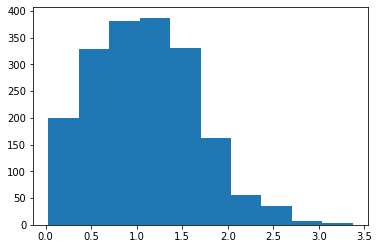

In [14]:
plt.hist(np.log(data['AMH'] + 1))

In [15]:
E2 = ['E2 Day 1','E2 Day 2','E2 Day 3','E2 Day 4','E2 Day 5','E2 Day 6','E2 Day 7','E2 Day 8','E2 Day 9',
     'E2 Day 10','E2 Day 11','E2 Day 12','E2 Day 13']
data['E2_last_day'] = data[E2].iloc[:, 1:].ffill(axis=1).iloc[:, -1]
data['E2_last_day'] = data['E2_last_day'].apply(lambda x: float(x) if isfloat(x) else -1)
data.head(2)

#>=16

,MPI,Treatment #,E2 Day 1,FSH Dose Day 1,E2 Day 2,FSH Dose Day 2,E2 Day 3,FSH Dose Day 3,E2 Day 4,FSH Dose Day 4,E2 Day 5,FSH Dose Day 5,E2 Day 6,FSH Dose Day 6,E2 Day 7,FSH Dose Day 7,E2 Day 8,FSH Dose Day 8,E2 Day 9,FSH Dose Day 9,E2 Day 10,FSH Dose Day 10,E2 Day 11,FSH Dose Day 11,E2 Day 12,FSH Dose Day 12,E2 Day 13,FD US #1 (Right),FD US #1 (Left),FD US #2 (Right),FD US #2 (left),FD US #3 (Right),FD US #3 (Left),FD US #4 (Right),FD US #4 (Left),FD US #5 (Right),FD US #5 (Left),Unnamed: 37,Patient Age (At Cycle Start),RSC MD,Primary RN,# prior IVF,# prior FET,# prior IUI,Affiliate,BMI,Height,Weight,International City,Country,Smoked?,Smoking Frequency,Number of Stimdays,#Cryo,Other ID1,Other ID2,Zip code,Lupron Protocol,Plan Stim Protocol,Diagnosis Primary,Diagnosis Secondary,Diagnosis Tertiary,Diagnosis Primary Modifier,Diagnosis Secondary Modifier,Diagnosis Tertiary Modifier,Special Studies 1,Special Studies 2,Semen Source,Semen Collection Method,Plan RN,Treatment #.1,Acupuncture,Cycle Type,Patient Type,FSH Level,Donor Shared Value,Calc AFC US Date,PICSI,AFC (Manual),AFC (Calc),Program ID,Semen Cryo,No ET intended,Day 1,Med1,Med2,Med3,Med4,hCG Drug Name,Maximum E2 level,Cycle Number,Total IUs in Stim Cycle,E2 on HCG Date,#Follicles > 14 mm on day of HCG,P4 on HCG Date,AMH,AMH Date,Last Endo Measurement,Minimal Stim,Retrieval Date,No. of Retrieved Oocytes,Retrieval MD,Lab Log #,ET date,US performed @ ET,No. Of Transfered Embryos,Transfer Method,Transfer MD,Day of ET,No ET,Reason for No ET,US Visualization,Elective SET (Y/N),Medical SET (Y/N),Was eSet Offered,Day of retrieval,Anesthetist,In vitro Maturation,Other No ET Reason,No. of Inseminated Oocytes,#Fert method of ICSI,#Fert method of IVF,No. of Fertilized Oocytes,Culture Medium,Incubator Number,#MI,#MII,#GV,% of Normally Fertilized Eggs,# with destiny equals discard,Assisted Hatching,Poor Grade Embryos,Fair Grade Embryos,Good Grade Embryos,ICSI SART Report,Blast Conversion,Total Blast Conversion,Insem Medium,Number Fertilized (ICSI),Number Fertilized (IVF),Culture Incubators,Embryo Banking,Oocyte Banking,No. of Frozen Embryos,No. of Frozen Oocytes,#Vit,No. of Survived Embryos After Thaw,Embryo Age @ Freeze,No. of Thawed Embryos,Thawing Date,Instrument,Protocol,Program,No. of Survived Oocytes After Thaw,No. of Thawed Oocytes,No. of Embryos Frozen-Day 3,No. of Embryos Frozen-Day 5,No. of Embryos Frozen-Day 6,No. of Embryos Frozen-Day 7,No. of Embryos Frozen-Day 8,Cycle Outcome,Pregnancy Outcome,Canceled Cycle,No. of Sacs,Fetal Cardiac Activity,No. of Live Born Babies,Hospitalization Occurred,Initial hCG,Complications,Cycle canceled reason,Cycle canceled date,Therapeutic Reduction,Therapeutic Reduction Date,Initial hcg Date,Birth Date,Week of Delivery,Reason Converted,Converted From IVF,Birth Defect,Gravidity,Prior pre-term,Prior full term,Prior SAB,Prior Biochem,Ethnicity,PGD,Reason 4 PGD,CGH Method,# PGD Suitable for Transfer,"Cells Biopsied, Aneuploidy","Cells Biopsied, Translocation","Cells Biopsied, Inversions","Cells Biopsied, Single Gene","PGD Lab, Aneuploidy","PGD Lab, Translocation","PGD Lab, Inversions","PGD Lab, Single Gene",No. of embryos biopsied,No. of embryos diagnosed,pregnant,male_infertility,FD_right_last_day,FD_left_last_day,max_FD_left,max_FD_right,max_FD,FD_right_count,FD_left_count,FD_count,E2_last_day
0,34000123,2612100,NaN,300.0,NaN,300.0,NaN,300.0,NaN,300.0,96.14,300.0,NaN,300.0,NaN,300.0,357.8,300.0,NaN,300.0,NaN,300.0,1030,300.0,NaN,300.0,NaN,"9.5,9,7.5","10.5,7,6.5","15,12,11","12,8","16,16,15.5,8","16.5,14.5,12",",,21,19,16","19,16,15.5,15,14.5",NaN,NaN,NaN,36,"Amy R. Criniti, MD",Kirkland Team,0,0,0,NaN,24.9,62.0,136.0,NaN,UNITED STATES,No,NaN,12.0,0,NaN,NaN,98012,LPL 10/5,FSH/HMG,"Other tubal disease, no hydro",Not Entered,Not Entered,NaN,NaN,NaN,NaN,NaN,Partner,Ejaculation,"Burchell, Kimberly",2612100,NaN,IVF,Autologous,NaN,NaN,2019-02-01,NaN,NaN,4,NaN,N,N,2019-02-04,Lupron,Gonal F MD,Menopur,Crinone,HCG,1482.0,1,4560.0,1482.0,8,NaN,1.99,201

In [16]:
#'Number of Stimdays' = -3642 for this one sample, set it to mean
data.loc[677,'Number of Stimdays'] = 0
data.loc[677,'Number of Stimdays'] = data['Number of Stimdays'].mean()

data['Number of Stimdays'] = data['Number of Stimdays'].apply(lambda x: x if x <= MAX_STIM_DAY else 15)

#mean imputation on BMI, since there's only 6 samples missing
data.loc[data['BMI']==0, 'BMI']=data['BMI'].mean()

In [17]:
#Combine Categories of protocol
data['Lupron Protocol'] = data['Lupron Protocol'].apply(lambda x: 'LPL 10/5' if (x == 'LDR/LPL' or x == 'Lupron 10/5') else x)

#drop unstimulated
data = data[data['Lupron Protocol'] != 'Unstimulated']

In [18]:
#get max, min, start, end doses
doses = ['FSH Dose Day 1', 'FSH Dose Day 2', 'FSH Dose Day 3','FSH Dose Day 4','FSH Dose Day 5',
         'FSH Dose Day 6', 'FSH Dose Day 7', 'FSH Dose Day 8',
        'FSH Dose Day 9', 'FSH Dose Day 10', 'FSH Dose Day 11', 'FSH Dose Day 12']
data['max_dose'] = data[doses].max(skipna = True, axis = 1)
data['min_dose'] = data[doses].min(skipna = True, axis = 1)
data['end_dose'] = data[doses].iloc[:, 1:].ffill(axis=1).iloc[:, -1]
data['dose_change'] = data['max_dose'] != data['min_dose']

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

Relavant data for Goal #1 and 2

In [19]:
#personal data 
#   height & weight not included for now
#   'Smoking Frequency' not included as there's only 10 positive samples
personal_data = ['BMI','Smoked?','Patient Age (At Cycle Start)']

#past IVF related info
past_ivf = ['# prior IVF','# prior FET','# prior IUI']

#protocol
protocol = ['Lupron Protocol', 'Plan Stim Protocol']

#semen
semen = ['Semen Source','Semen Collection Method', 'Semen Cryo']

#measurement
#  FSH does day 1 is the only dose information available for prediction 
measure = ['AFC (Calc)', 'AMH', 'FSH Dose Day 1','max_dose','min_dose','end_dose', 'dose_change']

#target
target = 'Number of Stimdays'

#outcome
outcome = 'No. of Retrieved Oocytes'

#Last_visit
last_visit = ['max_FD','E2_last_day','FD_count']

#past_stimulation_info(for pregnancy prediction)
past_stimulation = ['No. of Inseminated Oocytes', 'No. of Fertilized Oocytes', 'pregnant']

feature = list(set().union(personal_data, past_ivf, protocol, measure))
full = [target, outcome]
full.extend(feature)
full.extend(past_stimulation)
full.extend(last_visit)

In [20]:
def log_transform(df, col_list):
    for col in col_list:
        df.loc[col] = np.log(df[col] + 1/2)
        
def cat_transform(df, col_list):
    for col in col_list:
        df[col] = df[col].astype('category')

col_for_log_transform = ['AMH', 'AFC (Calc)','E2_last_day']
col_for_cat = ['Smoked?','Lupron Protocol','Plan Stim Protocol','Semen Source',
               'Semen Collection Method','Semen Cryo']

log_transform(data, col_for_log_transform)
#cat_transform(data, col_for_cat) ??

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Clustering

In [21]:
def normalize_num(df):
    column_names_to_normalize = df.select_dtypes(include=['int64','float64']).columns
    x = df[column_names_to_normalize].values
    minmaxscaler = MinMaxScaler()
    x_scaled = minmaxscaler.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df.index)
    df.loc[:,column_names_to_normalize] = df_temp
    return df

reduced_dataset = data[full].copy()
reduced_dataset.dropna(inplace=True)
X = reduced_dataset[feature]
X = normalize_num(X)


/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
X

,Lupron Protocol,end_dose,AMH,AFC (Calc),Smoked?,# prior FET,max_dose,min_dose,# prior IVF,BMI,Plan Stim Protocol,FSH Dose Day 1,Patient Age (At Cycle Start),dose_change,# prior IUI
0,LPL 10/5,0.500000,0.069578,0.015152,No,0.000000,0.500000,0.651163,0.000000,0.347826,FSH/HMG,0.600000,0.52,0.0,0.000000
2,Antagonist,0.666667,0.061058,0.056818,No,0.000000,0.666667,0.825581,0.000000,0.347826,FSH/HMG,0.800000,0.68,0.0,0.545455
3,Antagonist,0.833333,0.098332,0.018939,Yes,0.000000,0.833333,1.000000,0.076923,0.695652,FSH/HMG,1.000000,0.60,0.0,0.000000
4,Antagonist,0.388889,0.082357,0.083333,Unknown,0.000000,0.500000,0.534884,0.000000,0.708075,FSH/HMG,0.600000,0.56,1.0,0.000000
5,Antagonist,0.500000,0.183529,0.000000,Yes,0.000000,0.500000,0.651163,0.076923,0.586957,FSH/HMG,0.600000,0.56,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2079,Lupron Microdose,0.666667,0.042953,0.000000,No,0.142857,0.666667,0.825581,0.076923,0.503106,FSH/HMG,0.800000,0.56,0.0,0.090909
2080,Antagonist,0.277778,0.206958,0.000000,Unknown,0.000000,0.277778,0.418605,0.000000,0.503106,FSH/HMG,0.333333,0.52,0.0,0.000000
2081,Lupron Microdose,0.833333,0.105431,0.000000,No,0.142857,0.833333,1.000000,0.461538,0.276398,FSH/HMG,1.000000,0.56,0.0,0.000000
2082,Antagonist,0.333333,0.194888,0.000000,No,0.000000,0.333333,0.476744,0.000000,0.388199,FSH/HMG,0.400000,0.48,0.0,0.000000


In [23]:
reduced_dataset['ret_oocy_cat'] = reduced_dataset['No. of Retrieved Oocytes'].apply(lambda x: 0 if x <= 10
                                                              else 1)
reduced_dataset['mat_oocy_cat'] = reduced_dataset['No. of Inseminated Oocytes'].apply(lambda x: 0 if x <= 10
                                                              else 1)

In [24]:
reduced_dataset

,Number of Stimdays,No. of Retrieved Oocytes,Lupron Protocol,end_dose,AMH,AFC (Calc),Smoked?,# prior FET,max_dose,min_dose,# prior IVF,BMI,Plan Stim Protocol,FSH Dose Day 1,Patient Age (At Cycle Start),dose_change,# prior IUI,No. of Inseminated Oocytes,No. of Fertilized Oocytes,pregnant,max_FD,E2_last_day,FD_count,ret_oocy_cat,mat_oocy_cat
0,12.0,6.0,LPL 10/5,300.0,1.990,4.0,No,0.0,300.0,300.0,0.0,24.9,FSH/HMG,300.0,36.0,0.0,0.0,6.0,6.0,1.0,21.0,1030.0,5.0,0,0
2,9.0,23.0,Antagonist,375.0,1.750,15.0,No,0.0,375.0,375.0,0.0,24.9,FSH/HMG,375.0,40.0,0.0,6.0,19.0,11.0,1.0,19.0,3685.0,6.0,1,1
3,10.0,17.0,Antagonist,450.0,2.800,5.0,Yes,0.0,450.0,450.0,1.0,36.1,FSH/HMG,450.0,38.0,0.0,0.0,7.0,6.0,1.0,19.0,3557.0,5.0,1,0
4,9.0,29.0,Antagonist,250.0,2.350,22.0,Unknown,0.0,300.0,250.0,0.0,36.5,FSH/HMG,300.0,37.0,1.0,0.0,19.0,15.0,1.0,18.0,3629.0,4.0,1,1
5,9.0,17.0,Antagonist,300.0,5.200,0.0,Yes,0.0,300.0,300.0,1.0,32.6,FSH/HMG,300.0,37.0,0.0,0.0,13.0,11.0,1.0,22.0,1421.0,5.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2079,12.0,12.0,Lupron Microdose,375.0,1.240,0.0,No,1.0,375.0,375.0,1.0,29.9,FSH/HMG,375.0,37.0,0.0,1.0,6.0,2.0,0.0,20.0,3555.0,5.0,1,0
2080,8.0,12.0,Antagonist,200.0,5.860,0.0,Unknown,0.0,200.0,200.0,0.0,29.9,FSH/HMG,200.0,36.0,0.0,0.0,6.0,4.0,1.0,19.0,3645.0,6.0,1,0
2081,9.0,9.0,Lupron Microdose,450.0,3.000,0.0,No,1.0,450.0,450.0,6.0,22.6,FSH/HMG,450.0,37.0,0.0,0.0,4.0,3.0,0.0,19.0,3817.0,2.0,0,0
2082,10.0,14.0,Antagonist,225.0,5.520,0.0,No,0.0,225.0,225.0,0.0,26.2,FSH/HMG,225.0,35.0,0.0,0.0,12.0,12.0,1.0,21.0,1990.0,11.0,1,1


We calculate feature importance score on the entire dataset:

In [25]:
def create_dummies(X):
    cat_feature = X.select_dtypes(exclude=['int64','float64']).columns
    num_feature = X.select_dtypes(include=['int64','float64']).columns
    Xcat = X[cat_feature]
    Xnum = X[num_feature]

    dum_df = pd.get_dummies(Xcat, columns=cat_feature)
    return Xnum.join(dum_df)


def get_r_square(X, Y, rep):
    X_dummy = create_dummies(X)
    res = 0;
    kf = KFold(n_splits=rep)
    kf.get_n_splits(X_dummy)
    for train_index, test_index in kf.split(X_dummy):
        X_train, X_test = X_dummy.iloc[train_index,:], X_dummy.iloc[test_index,:]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        rf = LinearRegression()
        #rf = RandomForestRegressor(n_estimators = 1000)
        rf.fit(X_train, Y_train)
        res += r2_score(Y_test, rf.predict(X_test))
    return res/rep


def generate_weight(dataset, feature, target, rep):
    X = dataset[feature]
    Y = dataset[target]
    n = len(feature)
    res = np.ones(n)
    #full model
    R_2_full = get_r_square(X, Y, rep)
    for i in range(n):
        feature_partial = [x for x in range(n) if x != i]
        X_partial = X.iloc[:,feature_partial]
        R_2_cur = get_r_square(X_partial, Y, rep)
        res[i] = R_2_full - R_2_cur
    return res, R_2_full

<BarContainer object of 15 artists>

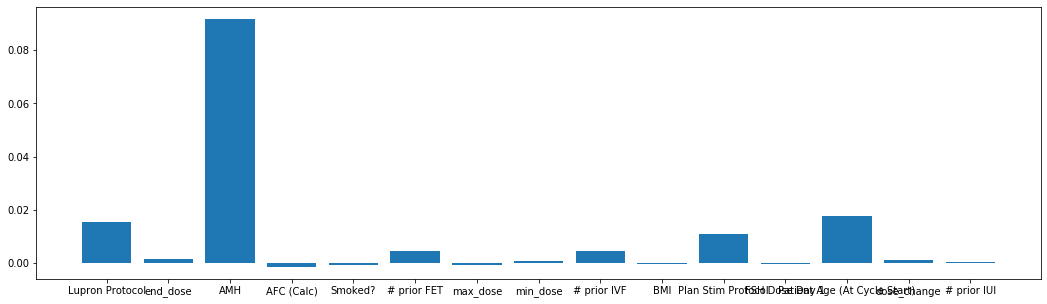

In [26]:
#feature.extend(last_visit)
weight_ori, R_2_full = generate_weight(reduced_dataset, feature, 'No. of Fertilized Oocytes', 5)

f, ax = plt.subplots(figsize=(18,5))
plt.bar(feature,weight_ori, width=0.8)

In [27]:
feature_l = ['AMH',
 'AFC (Calc)',
 'FSH Dose Day 1',
 'End Dose',
 'BMI',
 'Dose Changed?',
 'Min Dose',
 'Smoked?',
 'Max Dose',
 '# prior IUI',
 '# prior IVF',
 'Lupron Protocol',
 '# prior FET',
 'Age',
 'Plan Stim Protocol']

Text(0.5, 1.0, 'Feature improtance of pre-IVF variables on retrieved oocytes count')

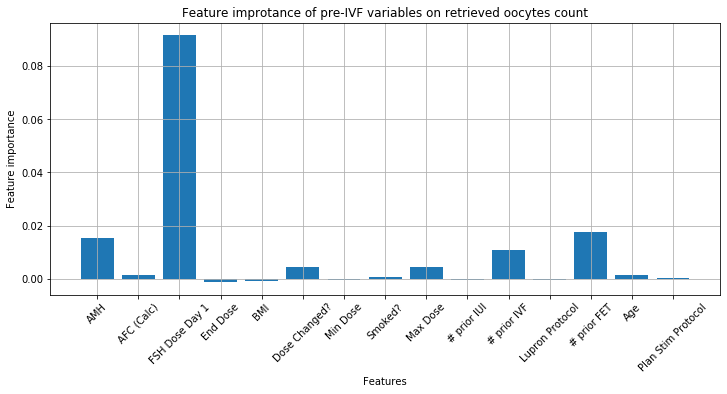

In [28]:
plt.figure(figsize=(12,5))
plt.bar(feature_l,weight_ori, width=0.8)
plt.grid()
plt.ylabel('Feature importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.title('Feature improtance of pre-IVF variables on retrieved oocytes count')

<BarContainer object of 15 artists>

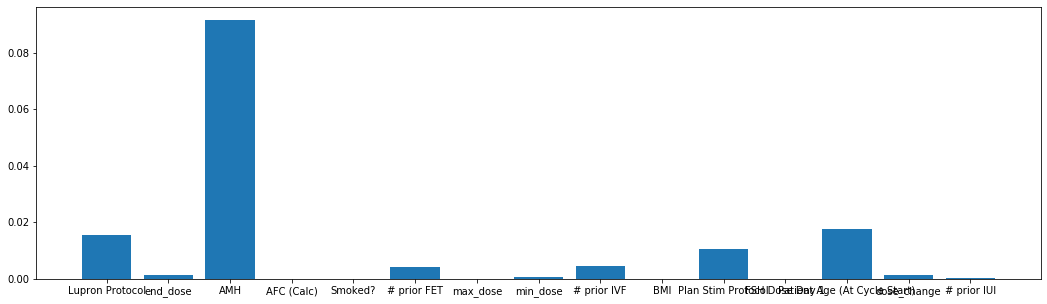

In [29]:
weight = np.array([max(x, 0) for x in weight_ori])

f, ax = plt.subplots(figsize=(18,5))
plt.bar(feature,weight, width=0.8)

In [30]:
#kernel K-means clustering
n_clusters = range(20,200,10)
s_score = np.zeros(len(n_clusters))
min_size = np.zeros(len(n_clusters))
i = 0
dm = gower.gower_matrix(X, weight = weight);
for n in n_clusters:
    km = KMeans(n_clusters=n, random_state=0).fit(dm)
    cluster_ld = pd.Series(km.labels_).astype('int64')
    reduced_dataset.reset_index(drop=True, inplace = True)
    reduced_dataset['cluster_id'] = cluster_ld
    s_score[i] = silhouette_score(dm, cluster_ld)
    min_size[i] = reduced_dataset.groupby('cluster_id')['Number of Stimdays'].count().min()
    i += 1
    


<BarContainer object of 18 artists>

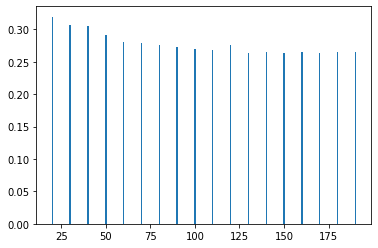

In [31]:
plt.bar(n_clusters, s_score)

<BarContainer object of 18 artists>

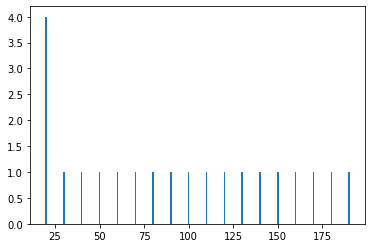

In [32]:
plt.bar(n_clusters, min_size)

In [33]:
reduced_dataset.groupby('cluster_id')['Number of Stimdays'].count().sort_values()

cluster_id
94      1
167     1
31      1
161     1
37      1
       ..
48     22
0      23
13     23
80     24
102    29
Name: Number of Stimdays, Length: 190, dtype: int64

In [34]:
reduced_dataset.groupby('cluster_id')['Number of Stimdays'].count().min()

1

In [35]:
silhouette_score(dm, cluster_ld)

0.26538676

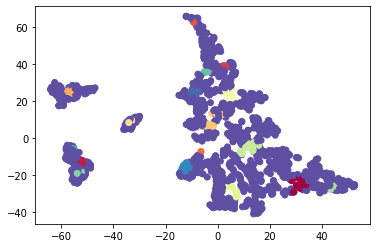

In [36]:
tsne = TSNE(n_components = 2).fit_transform(dm)
plt.scatter(tsne[:,0],tsne[:,1], c=[matplotlib.cm.Spectral(float(i)/20) for i in km.labels_])
#plt.scatter(tsne[:,0],tsne[:,1])

Text(0.5, 0.98, '')

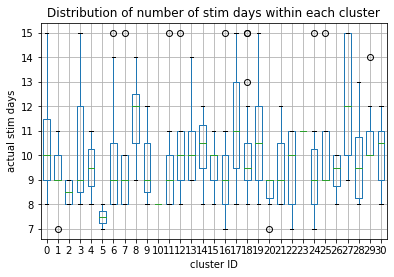

In [37]:
reduced_dataset[reduced_dataset['cluster_id'] <= 30].boxplot(column=['Number of Stimdays'], by=['cluster_id'], widths = 0.6)
plt.ylabel('actual stim days')
plt.xlabel('cluster ID')
plt.title('Distribution of number of stim days within each cluster')
plt.suptitle("")

In [38]:
reduced_dataset

,Number of Stimdays,No. of Retrieved Oocytes,Lupron Protocol,end_dose,AMH,AFC (Calc),Smoked?,# prior FET,max_dose,min_dose,# prior IVF,BMI,Plan Stim Protocol,FSH Dose Day 1,Patient Age (At Cycle Start),dose_change,# prior IUI,No. of Inseminated Oocytes,No. of Fertilized Oocytes,pregnant,max_FD,E2_last_day,FD_count,ret_oocy_cat,mat_oocy_cat,cluster_id
0,12.0,6.0,LPL 10/5,300.0,1.990,4.0,No,0.0,300.0,300.0,0.0,24.9,FSH/HMG,300.0,36.0,0.0,0.0,6.0,6.0,1.0,21.0,1030.0,5.0,0,0,55
1,9.0,23.0,Antagonist,375.0,1.750,15.0,No,0.0,375.0,375.0,0.0,24.9,FSH/HMG,375.0,40.0,0.0,6.0,19.0,11.0,1.0,19.0,3685.0,6.0,1,1,30
2,10.0,17.0,Antagonist,450.0,2.800,5.0,Yes,0.0,450.0,450.0,1.0,36.1,FSH/HMG,450.0,38.0,0.0,0.0,7.0,6.0,1.0,19.0,3557.0,5.0,1,0,133
3,9.0,29.0,Antagonist,250.0,2.350,22.0,Unknown,0.0,300.0,250.0,0.0,36.5,FSH/HMG,300.0,37.0,1.0,0.0,19.0,15.0,1.0,18.0,3629.0,4.0,1,1,142
4,9.0,17.0,Antagonist,300.0,5.200,0.0,Yes,0.0,300.0,300.0,1.0,32.6,FSH/HMG,300.0,37.0,0.0,0.0,13.0,11.0,1.0,22.0,1421.0,5.0,1,1,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,12.0,12.0,Lupron Microdose,375.0,1.240,0.0,No,1.0,375.0,375.0,1.0,29.9,FSH/HMG,375.0,37.0,0.0,1.0,6.0,2.0,0.0,20.0,3555.0,5.0,1,0,136
1587,8.0,12.0,Antagonist,200.0,5.860,0.0,Unknown,0.0,200.0,200.0,0.0,29.9,FSH/HMG,200.0,36.0,0.0,0.0,6.0,4.0,1.0,19.0,3645.0,6.0,1,0,159
1588,9.0,9.0,Lupron Microdose,450.0,3.000,0.0,No,1.0,450.0,450.0,6.0,22.6,FSH/HMG,450.0,37.0,0.0,0.0,4.0,3.0,0.0,19.0,3817.0,2.0,0,0,105
1589,10.0,14.0,Antagonist,225.0,5.520,0.0,No,0.0,225.0,225.0,0.0,26.2,FSH/HMG,225.0,35.0,0.0,0.0,12.0,12.0,1.0,21.0,1990.0,11.0,1,1,159


In [39]:
data[data['Number of Stimdays'] == 15].count()

MPI               300
Treatment #       300
E2 Day 1            7
FSH Dose Day 1    250
E2 Day 2            8
                 ... 
E2_last_day       263
max_dose          298
min_dose          298
end_dose          298
dose_change       300
Length: 214, dtype: int64

For Goal 1

In [40]:
#for each cluster_id, what is the in cluster max oocytes retrieved
s = reduced_dataset.groupby(['cluster_id'])['No. of Retrieved Oocytes'].max()
reduced_dataset['temp'] = reduced_dataset['cluster_id'].apply(lambda x: s[x])
#find the rows corresponding to these 'in group best results'
tempframe = reduced_dataset[(reduced_dataset['temp']==reduced_dataset['No. of Retrieved Oocytes'])]
#for multiple best results, take the one with less stimday for safety
ind = tempframe.groupby(['cluster_id'])['Number of Stimdays'].min()

In [41]:
#code inferred stim_days
reduced_dataset['inferred_stim_days'] = reduced_dataset['cluster_id'].apply(lambda x: min(MAX_STIM_DAY, ind[x]))

For Goal 2

In [42]:
tempframe_g2 = reduced_dataset[(reduced_dataset['No. of Retrieved Oocytes'] >= MIN_ACCEPTABLE_OOCYTES)]
ind_min = tempframe_g2.groupby(['cluster_id'])['Number of Stimdays'].min()
ind_max = tempframe_g2.groupby(['cluster_id'])['Number of Stimdays'].max()

In [43]:
reduced_dataset['min_acceptable_stim_days'] = reduced_dataset['cluster_id'].apply(
    lambda x: ind_min[x] if(ind_min.get(x)) else ind[x])
reduced_dataset['max_acceptable_stim_days'] = reduced_dataset['cluster_id'].apply(
    lambda x: ind_max[x] if(ind_max.get(x)) else ind[x])

reduced_dataset = reduced_dataset.drop(columns = ['temp'])
reduced_dataset.head(15)

,Number of Stimdays,No. of Retrieved Oocytes,Lupron Protocol,end_dose,AMH,AFC (Calc),Smoked?,# prior FET,max_dose,min_dose,# prior IVF,BMI,Plan Stim Protocol,FSH Dose Day 1,Patient Age (At Cycle Start),dose_change,# prior IUI,No. of Inseminated Oocytes,No. of Fertilized Oocytes,pregnant,max_FD,E2_last_day,FD_count,ret_oocy_cat,mat_oocy_cat,cluster_id,inferred_stim_days,min_acceptable_stim_days,max_acceptable_stim_days
0,12.0,6.0,LPL 10/5,300.0,1.99,4.0,No,0.0,300.0,300.0,0.0,24.9,FSH/HMG,300.0,36.0,0.0,0.0,6.0,6.0,1.0,21.0,1030.0,5.0,0,0,55,8.0,8.0,15.0
1,9.0,23.0,Antagonist,375.0,1.75,15.0,No,0.0,375.0,375.0,0.0,24.9,FSH/HMG,375.0,40.0,0.0,6.0,19.0,11.0,1.0,19.0,3685.0,6.0,1,1,30,9.0,9.0,9.0
2,10.0,17.0,Antagonist,450.0,2.80,5.0,Yes,0.0,450.0,450.0,1.0,36.1,FSH/HMG,450.0,38.0,0.0,0.0,7.0,6.0,1.0,19.0,3557.0,5.0,1,0,133,10.0,9.0,15.0
3,9.0,29.0,Antagonist,250.0,2.35,22.0,Unknown,0.0,300.0,250.0,0.0,36.5,FSH/HMG,300.0,37.0,1.0,0.0,19.0,15.0,1.0,18.0,3629.0,4.0,1,1,142,9.0,8.0,9.0
4,9.0,17.0,Antagonist,300.0,5.20,0.0,Yes,0.0,300.0,300.0,1.0,32.6,FSH/HMG,300.0,37.0,0.0,0.0,13.0,11.0,1.0,22.0,1421.0,5.0,1,1,54,11.0,8.0,11.0
5,9.0,29.0,LPL 10/5,150.0,4.13,25.0,No,1.0,150.0,150.0,2.0,24.3,FSH/HMG,150.0,31.0,0.0,0.0,18.0,13.0,1.0,17.0,6281.0,6.0,1,1,81,9.0,9.0,10.0
6,11.0,7.0,Antagonist,375.0,2.97,15.0,Unknown,2.0,375.0,375.0,1.0,19.8,FSH/HMG,375.0,37.0,0.0,0.0,6.0,4.0,1.0,20.0,3207.0,7.0,0,0,77,9.0,9.0,11.0
7,12.0,8.0,Antagonist,450.0,1.47,13.0,No,1.0,450.0,450.0,3.0,22.0,FSH/HMG,450.0,38.0,0.0,0.0,5.0,4.0,1.0,21.0,1241.0,4.0,0,0,129,15.0,15.0,15.0
8,7.0,23.0,Antagonist,250.0,4.42,21.0,No,0.0,250.0,250.0,0.0,27.6,FSH/HMG,250.0,30.0,0.0,0.0,14.0,9.0,1.0,18.0,3092.0,4.0,1,1,101,10.0,7.0,11.0
9,9.0,11.0,LPL 10/5,300.0,2.47,12.0,No,0.0,300.0,300.0,0.0,21.6,FSH/HMG,300.0,35.0,0.0,0.0,11.0,6.0,1.0,21.0,3565.0,4.0,1,1,106,15.0,15.0,15.0


MODEL FITTING
---------------------------------------

In [44]:
#prep data, get dummies

X = reduced_dataset[feature]
y = reduced_dataset[['inferred_stim_days','min_acceptable_stim_days','max_acceptable_stim_days']]

cat_feature = X.select_dtypes(exclude=['int64','float64']).columns
num_feature = X.select_dtypes(include=['int64','float64']).columns
Xcat = X[cat_feature]
Xnum = X[num_feature]

dum_df = pd.get_dummies(Xcat, columns=cat_feature)
# merge with main df bridge_df on key values
X = Xnum.join(dum_df)
#just include these for later reference, won't regress on these
#X = X.join(reduced_dataset[['Number of Stimdays', 'No. of Inseminated Oocytes','No. of Fertilized Oocytes']])

X.head(4)

,end_dose,AMH,AFC (Calc),# prior FET,max_dose,min_dose,# prior IVF,BMI,FSH Dose Day 1,Patient Age (At Cycle Start),dose_change,# prior IUI,Lupron Protocol_Antagonist,Lupron Protocol_LPL 10/5,Lupron Protocol_Lupron Microdose,Smoked?_No,Smoked?_Unknown,Smoked?_Yes,Plan Stim Protocol_FSH Only,Plan Stim Protocol_FSH/HMG,Plan Stim Protocol_FSH/dilutedHCG,Plan Stim Protocol_Letrozole/FSH
0,300.0,1.99,4.0,0.0,300.0,300.0,0.0,24.9,300.0,36.0,0.0,0.0,0,1,0,1,0,0,0,1,0,0
1,375.0,1.75,15.0,0.0,375.0,375.0,0.0,24.9,375.0,40.0,0.0,6.0,1,0,0,1,0,0,0,1,0,0
2,450.0,2.80,5.0,0.0,450.0,450.0,1.0,36.1,450.0,38.0,0.0,0.0,1,0,0,0,0,1,0,1,0,0
3,250.0,2.35,22.0,0.0,300.0,250.0,0.0,36.5,300.0,37.0,1.0,0.0,1,0,0,0,1,0,0,1,0,0


In [45]:
#test_train_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#three y's for three models
y_train_opt = y_train['inferred_stim_days'];
y_train_min = y_train['min_acceptable_stim_days'];
y_train_max = y_train['max_acceptable_stim_days'];

y_test_opt = y_test['inferred_stim_days'];
y_test_min = y_test['min_acceptable_stim_days'];
y_test_max = y_test['max_acceptable_stim_days'];

In [46]:
reduced_dataset['diff'] = reduced_dataset['Number of Stimdays'] - reduced_dataset['inferred_stim_days']

In [90]:
#Goal 1 and 2 fit
from sklearn.metrics import r2_score

rf = RandomForestRegressor(n_estimators = 10000, random_state = 1)
rf.fit(X_train, y_train_opt);

rf_min = RandomForestRegressor(n_estimators = 10000, random_state = 1)
rf_min.fit(X_train, y_train_min);

rf_max = RandomForestRegressor(n_estimators = 10000, random_state = 1)
rf_max.fit(X_train, y_train_max);

#performance
print('Mean absolute error for optimal day on test set is: ', mean_absolute_error(y_test_opt, rf.predict(X_test)))
print('Mean absolute error for min day on test set is: ', mean_absolute_error(y_test_min, rf_min.predict(X_test)))
print('Mean absolute error for max day on test set is: ', mean_absolute_error(y_test_max, rf_max.predict(X_test)))

print('R2 for optimal day on test set is: ', r2_score(y_test_opt, rf.predict(X_test)))
print('R2 for min day on test set is: ', r2_score(y_test_min, rf_min.predict(X_test)))
print('R2 for max day on test set is: ', r2_score(y_test_max, rf_max.predict(X_test)))

Mean absolute error for optimal day on test set is:  0.9709921630094045
Mean absolute error for min day on test set is:  0.7174849529780565
Mean absolute error for max day on test set is:  1.2083087774294672
R2 for optimal day on test set is:  0.33360472266430685
R2 for min day on test set is:  0.43141421525027723
R2 for max day on test set is:  0.4574579028441721


In [59]:
#Goal 3
y_train['fertilized_oocytes'] = reduced_dataset['No. of Fertilized Oocytes']
y_test['fertilized_oocytes'] = reduced_dataset['No. of Fertilized Oocytes']
#rf_oocy_ini = RandomForestRegressor(n_estimators = 10000, random_state = 1)
#rf_oocy_ini.fit(X_train, y_train['fertilized_oocytes'])

#print('Mean absolute error for fertilized oocyte count on test set is: ', 
#      mean_absolute_error(y_test['fertilized_oocytes'], rf_oocy_ini.predict(X_test)))

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from vecstack import stacking 
from vecstack import StackingTransformer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred) ** 0.5

def stacking(X_train, X_test, y_train,
            etc_n = 225, etc_max_depth = 5,
             knn_n = 4,
            rf_n = 10000,
            verbose = 0):
    lr = LinearRegression()
    etc = ExtraTreesRegressor(n_estimators=etc_n, max_depth=etc_max_depth)
    knn = KNeighborsRegressor(n_neighbors=4)
    rf = RandomForestRegressor(n_estimators=1000)


    # Initialize 1-st level models.
    models = [('lr', LinearRegression()),
              ('etc', ExtraTreesRegressor(n_estimators=etc_n, max_depth=etc_max_depth)),
              #('etc', ExtraTreesRegressor(criterion = 'mae', n_estimators=etc_n, max_depth=etc_max_depth)),
              #('knn', KNeighborsRegressor(weights= 'distance', n_neighbors=knn_n)),
              ('xgb', xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                             colsample_bynode=1, colsample_bytree=0.2653535353535354,
                                             gamma=0.00014563484775012445, importance_type='gain',
                                             learning_rate=0.004977023564332114,
                                             max_delta_step=0, max_depth=5, min_child_weight=1, 
                                             n_estimators=4000, 
                                             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
                                             reg_alpha=4.627332011878694, reg_lambda=0.5488819609789671,
                                             scale_pos_weight=1, subsample=0.06585858585858587,
                                             tree_method='exact', validate_parameters=1, verbosity=None)),
              ('rf', RandomForestRegressor(n_estimators=rf_n, n_jobs = -1))]
    

    # Compute stacking features
    stack = StackingTransformer(models, regression=True, verbose=verbose)

    # Fit
    stack = stack.fit(X_train, y_train)

    # Get your stacked features
    S_train = stack.transform(X_train)
    S_test = stack.transform(X_test)

    return S_train, S_test

def stacking_binary(X_train, X_test, y_train):
    lr = LogisticRegression()
    etc = ExtraTreesClassifier(n_estimators=225, max_depth=5)
    knn = KNeighborsRegressor(n_neighbors=4)
    rf = RandomForestRegressor(n_estimators=1000)


    # Initialize 1-st level models.
    models = [('svm', make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight="balanced"))),
              ('lr', make_pipeline(StandardScaler(), LogisticRegression(class_weight="balanced"))),
              ('etc', ExtraTreesClassifier(n_estimators=10000, max_depth=8, class_weight="balanced")),
              ('rf', RandomForestClassifier(n_estimators=10000, n_jobs = -1, class_weight="balanced"))]
    

    # Compute stacking features
    stack = StackingTransformer(models, regression=False, verbose=2)

    # Fit
    stack = stack.fit(X_train, y_train)

    # Get your stacked features
    S_train = stack.transform(X_train)
    S_test = stack.transform(X_test)

    return S_train, S_test

In [51]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#Goal 3 progresssive
def prog_predict(X_train, X_test, add_feature, target,
                etc_n = 225, etc_max_depth = 5,
                 knn_n = 4,
                rf_n = 10000,
                verbose = 0):
    X_train_copy, X_test_copy = X_train.copy(), X_test.copy()
    for col in add_feature:
        X_train_copy.loc[:,col], X_test_copy.loc[:,col] = reduced_dataset[col], reduced_dataset[col]
    y_train.loc[:,target], y_test.loc[:,target] = reduced_dataset[target], reduced_dataset[target]
    S_train, S_test = stacking(X_train_copy, X_test_copy, y_train[target],
                              etc_n = etc_n, etc_max_depth = etc_max_depth,
                                 knn_n = knn_n,
                                    rf_n = rf_n,
                              verbose = verbose)
    model = LinearRegression()
    model.fit(S_train, y_train[target])
    return mean_absolute_error(y_test[target], model.predict(S_test)), model, S_test

def prog_predict_temp(X_train, X_test, add_feature, target,
                etc_n = 225, etc_max_depth = 5,
                 knn_n = 4,
                rf_n = 10000,
                verbose = 0):
    X_train_copy, X_test_copy = X_train.copy(), X_test.copy()
    for col in add_feature:
        X_train_copy.loc[:,col] = reduced_dataset[col]
    y_train.loc[:,target], y_test.loc[:,target] = reduced_dataset[target], reduced_dataset[target]
    S_train, S_test = stacking(X_train_copy, X_test_copy, y_train[target],
                              etc_n = etc_n, etc_max_depth = etc_max_depth,
                                 knn_n = knn_n,
                                    rf_n = rf_n,
                              verbose = verbose)
    model = LinearRegression()
    model.fit(S_train, y_train[target])
    return model, S_test


def prog_predict_binary(X_train, X_test, add_feature, target):
    X_train_copy, X_test_copy = X_train.copy(), X_test.copy()
    for col in add_feature:
        X_train_copy.loc[:,col], X_test_copy.loc[:,col] = reduced_dataset[col], reduced_dataset[col]
    y_train.loc[:,target], y_test.loc[:,target] = reduced_dataset[target], reduced_dataset[target]
    S_train, S_test = stacking_binary(X_train_copy, X_test_copy, y_train[target])
    #model = make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight="balanced"))
    model = LogisticRegression(class_weight="balanced")
    model.fit(S_train, y_train[target])
    pred = model.predict(S_test)
    
    res = confusion_matrix(y_test[target], pred)
    return res, model, S_test

In [52]:
d = {'AMH': X_train['AMH'].to_numpy()}
X_train_t = pd.DataFrame(data=d)


In [53]:
d = {'AMH': X_test['AMH'].to_numpy()}
X_test_t = pd.DataFrame(data=d)

In [54]:
y_train['Number of Stimdays'] = reduced_dataset['Number of Stimdays']
y_test['Number of Stimdays'] = reduced_dataset['Number of Stimdays']

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
y_train['Number of Stimdays'] = reduced_dataset['Number of Stimdays']
y_test['Number of Stimdays'] = reduced_dataset['Number of Stimdays']



/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
def prog_predict_single(X_train, X_test, add_feature, target, model,
                verbose = 0):
    X_train_copy, X_test_copy = X_train.copy(), X_test.copy()
    for col in add_feature:
        X_train_copy.loc[:,col], X_test_copy.loc[:,col] = reduced_dataset[col], reduced_dataset[col]
    y_train.loc[:,target], y_test.loc[:,target] = reduced_dataset[target], reduced_dataset[target]
    model.fit(X_train, y_train[target])
    return mean_absolute_error(y_test[target], model.predict(X_test)), model

In [72]:
v, reg0 = prog_predict_single(X_train, X_test, [], 'Number of Stimdays', ExtraTreesRegressor(n_estimators=225, max_depth=5),
                                        verbose = 1)
v

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


1.3814685355932474

In [57]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV
xgb = xgboost.XGBRegressor()
param_grid = {"colsample_bytree": np.linspace(0.01,0.8,100),
              "gamma": np.logspace(-4, 0, 50),
              "learning_rate": np.logspace(-7, -2, 100),
              "max_depth": [1,2,3,4,5,6,7,8,9,10],
              "n_estimators": [4000],
              "reg_alpha": np.logspace(-4, 2, 500),
                "reg_lambda": np.logspace(-4, 2, 500),
                 "subsample": np.linspace(0.01,0.8,100)}

xgb_oocy = RandomizedSearchCV(xgb, param_distributions=param_grid,
                                   n_iter=40, verbose=1)
xgb_oocy.fit(X_train, y_train['Number of Stimdays'])

('Mean absolute error for inseminated oocytes on test set (xgb) is: ', 
      mean_absolute_error(y_test['Number of Stimdays'], xgb_oocy.predict(X_test)))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.6min finished


('Mean absolute error for inseminated oocytes on test set (xgb) is: ',
 1.3622073320012107)

In [56]:
X_train['inferred_stim_days'] = y_train['inferred_stim_days']
X_test['inferred_stim_days'] = y_test['inferred_stim_days']

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [334]:
('Mean absolute error for inseminated oocytes on test set (xgb) is: ', 
      mean_absolute_error(y_test['Number of Stimdays'], np.ones(len(X_test)) * 10))

('Mean absolute error for inseminated oocytes on test set (xgb) is: ',
 1.3887147335423198)

In [328]:
X_train['inferred_stim_days'] = reduced_dataset['inferred_stim_days']

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_test.drop(columns=['inferred_stim_days'])
X_train.drop(columns=['inferred_stim_days'])



In [279]:
y_test['Number of Stimdays'].mean()

10.047021943573668

In [73]:
v, reg0, X_test_prog0 = prog_predict(X_train, X_test, [],'Number of Stimdays',
                                        verbose = 1)

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


task:         [regression]
metric:       [mean_absolute_error]
variant:      [A]
n_estimators: [4]

estimator  0: [lr: LinearRegression]
    MEAN:     [1.46745179] + [0.07470663]

estimator  1: [etc: ExtraTreesRegressor]
    MEAN:     [1.47754318] + [0.05445661]

estimator  2: [xgb: XGBRegressor]
    MEAN:     [1.46464777] + [0.06857189]

estimator  3: [rf: RandomForestRegressor]
    MEAN:     [1.49763540] + [0.05845131]

Train set was detected.
Transforming...

estimator  0: [lr: LinearRegression]
    DONE

estimator  1: [etc: ExtraTreesRegressor]
    DONE

estimator  2: [xgb: XGBRegressor]
    DONE

estimator  3: [rf: RandomForestRegressor]
    DONE

Transforming...

estimator  0: [lr: LinearRegression]
    DONE

estimator  1: [etc: ExtraTreesRegressor]
    DONE

estimator  2: [xgb: XGBRegressor]
    DONE

estimator  3: [rf: RandomForestRegressor]
    DONE



In [74]:
v

1.3550898689156028

In [75]:
diff = reg0.predict(X_test_prog0) - y_test['Number of Stimdays']

In [76]:
y_test['diff'] = diff

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Distribution of predicted vs actual stimulation days')

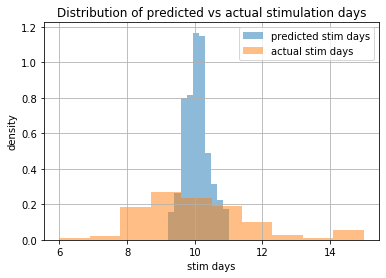

In [92]:
plt.hist(reg0.predict(X_test_prog0), bins = 10, density = True, alpha = 0.5, label = 'predicted stim days')
plt.hist(np.round(y_test['Number of Stimdays']), bins = 10, density = True, alpha = 0.5, label = 'actual stim days')
plt.legend()
plt.grid()
plt.xlabel('stim days')
plt.ylabel('density')
plt.title('Distribution of predicted vs actual stimulation days')

(array([0.03448276, 0.02507837, 0.01567398, 0.08777429, 0.17554859,
        0.20376176, 0.26332288, 0.1630094 , 0.01880878, 0.01253918]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 10 Patch objects>)

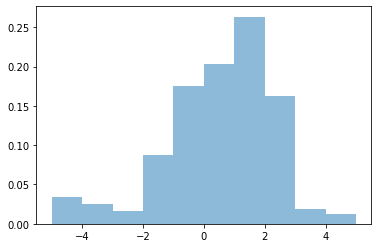

In [77]:
plt.hist(np.round(y_test['diff']), bins = 10, density = True, alpha = 0.5, label = 'actual stim days')

In [79]:
y = np.histogram(y_test['diff'].to_numpy(), bins=10, range=None, normed=None, weights=None, density=True)
y

(array([0.03425518, 0.02491286, 0.01557054, 0.09030912, 0.17439002,
        0.22110163, 0.24290039, 0.1650477 , 0.01245643, 0.01245643]),
 array([-5.4868016 , -4.48015805, -3.4735145 , -2.46687095, -1.4602274 ,
        -0.45358385,  0.5530597 ,  1.55970325,  2.5663468 ,  3.57299035,
         4.5796339 ]))

(array([353.,   0., 637.,   0., 389.,   0.,  87.,   0.,  24., 101.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

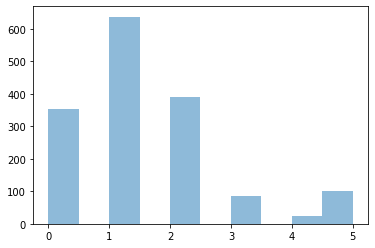

In [323]:
plt.hist(np.abs(np.round(reduced_dataset['Number of Stimdays']) - np.ones(len(reduced_dataset))*10), bins = 10, alpha = 0.5, label = 'actual stim days')



(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-3.8403903 , -3.82394943, -3.80750857, -3.7910677 , -3.77462684,
        -3.75818597, -3.74174511, -3.72530425, -3.70886338, -3.69242252,
        -3.67598165]),
 <a list of 10 Patch objects>)

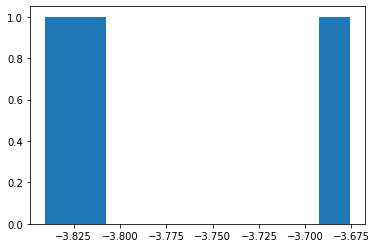

In [243]:
plt.hist(y_test[y_test['Number of Stimdays'] == 14]['diff'], bins = 10)

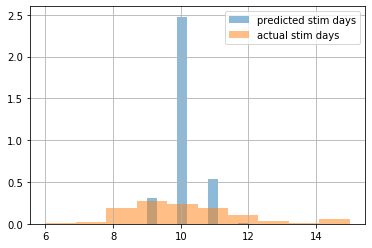

In [337]:

plt.hist(np.round(xgb_oocy.predict(X_test)), bins = 10, density = True, alpha = 0.5, label = 'predicted stim days')
plt.hist(np.round(y_test['Number of Stimdays']), bins = 10, density = True, alpha = 0.5, label = 'actual stim days')
plt.grid()
plt.legend()

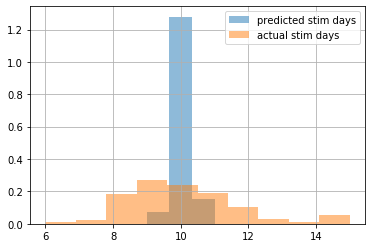

In [332]:
plt.hist(np.round(reg0.predict(X_test_prog0)), bins = 3, density = True, alpha = 0.5, label = 'predicted stim days')
plt.hist(np.round(y_test['Number of Stimdays']), bins = 10, density = True, alpha = 0.5, label = 'actual stim days')
plt.grid()
plt.legend()

In [ ]:
plt.hist(np.round(reg0.predict(X_test_prog0)), bins = 3, density = True, alpha = 0.5, label = 'predicted stim days')
plt.hist(np.round(y_test['Number of Stimdays']), bins = 10, density = True, alpha = 0.5, label = 'actual stim days')
plt.grid()
plt.legend()

(array([ 3.,  0.,  6.,  0., 53.,  0., 78.,  0., 68.,  0.,  0., 55.,  0.,
        29.,  0.,  8.,  0.,  3.,  0., 16.]),
 array([ 6.  ,  6.45,  6.9 ,  7.35,  7.8 ,  8.25,  8.7 ,  9.15,  9.6 ,
        10.05, 10.5 , 10.95, 11.4 , 11.85, 12.3 , 12.75, 13.2 , 13.65,
        14.1 , 14.55, 15.  ]),
 <a list of 20 Patch objects>)

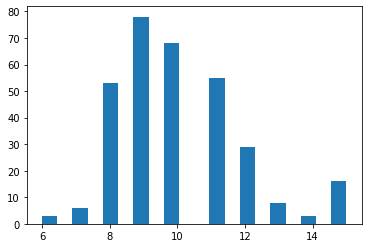

In [254]:
plt.hist(y_test['Number of Stimdays'], bins = 20)

In [256]:
y_test['Number of Stimdays'].unique()

array([11.,  9., 10.,  7., 12.,  8., 15., 13., 14.,  6.])

model, S_test = stacking(X_train, X_test, y_train['fertilized_oocytes'])

lr = LinearRegression()
lr.fit(model, y_train['fertilized_oocytes'])

In [339]:
import warnings
warnings.filterwarnings('ignore')

In [212]:
#random search
params_etc_n = np.arange(10,500,10)
params_etc_d = np.arange(1,15,1)
params_knn_n = np.arange(2,15,1)
params_rf_n = np.arange(100, 10000, 100)

In [340]:
n_trial = 100

res = []

for i in range(n_trial):
    etc_n = np.random.choice(params_etc_n, 1).item()
    etc_max_depth = np.random.choice(params_etc_d, 1).item()
    knn_n = np.random.choice(params_knn_n, 1).item()
    rf_n = np.random.choice(params_rf_n, 1).item()

    v, reg0, X_test_prog0 = prog_predict(X_train, X_test, [],'Number of Stimdays',
                                        etc_n = etc_n, etc_max_depth = etc_max_depth,
                                         knn_n = knn_n,
                                            rf_n = rf_n)
    res.append([etc_n, etc_max_depth, knn_n, rf_n, v])
    print([etc_n, etc_max_depth, knn_n, rf_n, v])

[470, 8, 8, 3000, 1.3673659815613]
[470, 1, 8, 7700, 1.3642452500066424]
[440, 13, 2, 8300, 1.3624335634583802]
[310, 10, 13, 8200, 1.3652553516685375]
[450, 7, 6, 6600, 1.366481028542113]
[380, 4, 4, 300, 1.3670021206871257]
[280, 7, 4, 4600, 1.36681358301995]
[170, 9, 6, 3100, 1.3649487531786149]
[350, 3, 4, 4500, 1.3657595931256534]
[210, 3, 10, 1300, 1.366298329830531]
[240, 2, 9, 2400, 1.3649515161075336]
[440, 6, 14, 2100, 1.3667367411222158]
[360, 12, 5, 6500, 1.364170881708528]
[160, 11, 2, 8500, 1.3647674786422548]
[300, 4, 12, 2500, 1.3664941392403827]
[10, 12, 7, 1700, 1.3620778081009166]
[460, 5, 3, 5700, 1.3658792590103186]
[150, 4, 7, 5100, 1.366327493196513]
[240, 10, 7, 6100, 1.3646919166093159]
[290, 12, 4, 100, 1.3648309711837372]
[380, 7, 9, 300, 1.366844094536013]
[350, 1, 9, 2100, 1.364318014625115]
[460, 9, 9, 4800, 1.3660654026395156]
[450, 9, 4, 7200, 1.3660287168940815]
[370, 4, 5, 300, 1.3652016153960085]
[140, 13, 4, 8900, 1.362086710701561]
[160, 7, 8, 7700,

In [84]:
reg0, X_test_prog0 = prog_predict_temp(X_train, test_df, ['Number of Stimdays'],'No. of Retrieved Oocytes',
                                        etc_n = 310, etc_max_depth = 5,
                                         knn_n = 8,
                                            rf_n = 3000,
                                    verbose = 2)


/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


task:         [regression]
metric:       [mean_absolute_error]
variant:      [A]
n_estimators: [4]

estimator  0: [lr: LinearRegression]
    fold  0:  [5.05582048]
    fold  1:  [5.16669990]
    fold  2:  [5.15283104]
    fold  3:  [5.55192029]
    ----
    MEAN:     [5.23181793] + [0.18968389]

estimator  1: [etc: ExtraTreesRegressor]
    fold  0:  [5.05116053]
    fold  1:  [5.02453567]
    fold  2:  [4.93431771]
    fold  3:  [5.19231712]
    ----
    MEAN:     [5.05058276] + [0.09258101]

estimator  2: [xgb: XGBRegressor]
    fold  0:  [4.83402412]
    fold  1:  [4.99980260]
    fold  2:  [5.07031215]
    fold  3:  [5.40182376]
    ----
    MEAN:     [5.07649066] + [0.20648903]

estimator  3: [rf: RandomForestRegressor]
    fold  0:  [4.85142453]
    fold  1:  [5.01892872]
    fold  2:  [5.05032390]
    fold  3:  [5.34842348]
    ----
    MEAN:     [5.06727516] + [0.17906744]

Train set was detected.
Transforming...

estimator  0: [lr: LinearRegression]
    model from fold  0: done

In [85]:
n = reg0.predict(X_test_prog0)
n

array([9.34811221, 9.32575907, 9.30340593, 9.28105279, 9.25869965,
       9.24491996, 9.2346036 , 9.30174351, 9.44735659, 9.50779087,
       9.37389383, 9.22798142, 9.35275247, 9.43091343])

Text(0.5, 1.0, 'Stim Days vs Predicted Retrieved Oocytes')

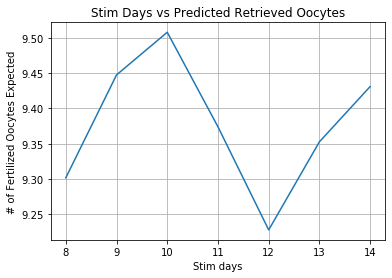

In [86]:
plt.plot(np.arange(8,15,1), n[-7:])
plt.grid()
plt.xlabel('Stim days')
plt.ylabel('# of Fertilized Oocytes Expected')
#plt.title('Stim Days vs Predicted Fertilized Oocytes')
plt.title('Stim Days vs Predicted Retrieved Oocytes')

In [80]:
test_v = list(X_test.iloc[2])

In [81]:
X_test.iloc[2]

end_dose                             375.00
AMH                                    0.73
AFC (Calc)                            20.00
# prior FET                            0.00
max_dose                             375.00
min_dose                             375.00
# prior IVF                            0.00
BMI                                   30.10
FSH Dose Day 1                       375.00
Patient Age (At Cycle Start)          36.00
dose_change                            0.00
# prior IUI                            0.00
Lupron Protocol_Antagonist             1.00
Lupron Protocol_LPL 10/5               0.00
Lupron Protocol_Lupron Microdose       0.00
Smoked?_No                             0.00
Smoked?_Unknown                        1.00
Smoked?_Yes                            0.00
Plan Stim Protocol_FSH Only            0.00
Plan Stim Protocol_FSH/HMG             1.00
Plan Stim Protocol_FSH/dilutedHCG      0.00
Plan Stim Protocol_Letrozole/FSH       0.00
Name: 1026, dtype: float64

In [82]:
extended_list = np.array([test_v+[i] for i in range(1,15,1)])
test_df = pd.DataFrame(extended_list)

In [83]:
test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,375.0,0.73,20.0,0.0,375.0,375.0,0.0,30.1,375.0,36.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,375.0,0.73,20.0,0.0,375.0,375.0,0.0,30.1,375.0,36.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0
2,375.0,0.73,20.0,0.0,375.0,375.0,0.0,30.1,375.0,36.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0
3,375.0,0.73,20.0,0.0,375.0,375.0,0.0,30.1,375.0,36.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0
4,375.0,0.73,20.0,0.0,375.0,375.0,0.0,30.1,375.0,36.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0
5,375.0,0.73,20.0,0.0,375.0,375.0,0.0,30.1,375.0,36.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,6.0
6,375.0,0.73,20.0,0.0,375.0,375.0,0.0,30.1,375.0,36.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,7.0
7,375.0,0.73,20.0,0.0,375.0,375.0,0.0,30.1,375.0,36.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,8.0
8,375.0,0.73,20.0,0.0,375.0,375.0,0.0,30.1,375.0,36.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,9.0
9,375.0,0.73,20.0,0.0,375.0,375.0,0.0,30.1,375.0,36.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,10.0


In [121]:
reduced_dataset.iloc[56]

Number of Stimdays                      10
No. of Retrieved Oocytes                24
AMH                                    2.5
AFC (Calc)                              11
FSH Dose Day 1                         300
end_dose                               300
BMI                                   24.3
dose_change                              0
min_dose                               300
Smoked?                                 No
max_dose                               300
# prior IUI                              0
# prior IVF                              0
Lupron Protocol                 Antagonist
# prior FET                              0
Patient Age (At Cycle Start)            34
Plan Stim Protocol                 FSH/HMG
No. of Inseminated Oocytes              23
No. of Fertilized Oocytes               21
pregnant                                 1
max_FD                                  20
E2_last_day                           3596
FD_count                                 8
ret_oocy_ca

In [151]:
X_test

,AMH,AFC (Calc),FSH Dose Day 1,end_dose,BMI,dose_change,min_dose,max_dose,# prior IUI,# prior IVF,# prior FET,Patient Age (At Cycle Start),Smoked?_No,Smoked?_Unknown,Smoked?_Yes,Lupron Protocol_Antagonist,Lupron Protocol_LPL 10/5,Lupron Protocol_Lupron Microdose,Plan Stim Protocol_FSH Only,Plan Stim Protocol_FSH/HMG,Plan Stim Protocol_FSH/dilutedHCG,Plan Stim Protocol_Letrozole/FSH
1098,2.970,0.0,375.0,375.0,23.0,0.0,375.0,375.0,0.0,0.0,0.0,30.0,1,0,0,1,0,0,0,1,0,0
772,1.370,11.0,225.0,150.0,27.1,1.0,150.0,225.0,0.0,2.0,1.0,36.0,1,0,0,0,1,0,0,1,0,0
1026,0.730,20.0,375.0,375.0,30.1,0.0,375.0,375.0,0.0,0.0,0.0,36.0,0,1,0,1,0,0,0,1,0,0
1138,1.300,20.0,300.0,275.0,24.9,1.0,275.0,300.0,0.0,1.0,0.0,36.0,0,1,0,0,1,0,0,1,0,0
640,1.200,0.0,300.0,300.0,23.6,0.0,300.0,300.0,1.0,2.0,0.0,38.0,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,0.632,2.0,375.0,375.0,39.3,1.0,275.0,375.0,0.0,0.0,0.0,43.0,0,0,1,1,0,0,0,1,0,0
791,0.098,9.0,225.0,150.0,30.4,1.0,150.0,225.0,0.0,0.0,0.0,45.0,0,1,0,0,0,1,0,1,0,0
521,3.940,49.0,225.0,225.0,24.6,0.0,225.0,225.0,0.0,0.0,0.0,37.0,1,0,0,1,0,0,0,1,0,0
56,2.500,11.0,300.0,300.0,24.3,0.0,300.0,300.0,0.0,0.0,0.0,34.0,1,0,0,1,0,0,0,1,0,0


In [163]:
reduced_dataset.iloc[1026]

Number of Stimdays                      10
No. of Retrieved Oocytes                 7
AMH                                   0.73
AFC (Calc)                              20
FSH Dose Day 1                         375
end_dose                               375
BMI                                   30.1
dose_change                              0
min_dose                               375
Smoked?                            Unknown
max_dose                               375
# prior IUI                              0
# prior IVF                              0
Lupron Protocol                 Antagonist
# prior FET                              0
Patient Age (At Cycle Start)            36
Plan Stim Protocol                 FSH/HMG
No. of Inseminated Oocytes               6
No. of Fertilized Oocytes                5
pregnant                                 0
max_FD                                  22
E2_last_day                           2843
FD_count                                 7
ret_oocy_ca

In [153]:
v, reg0, X_test_prog0 = prog_predict(X_train, X_test, [],'No. of Fertilized Oocytes',
                                        etc_n = 400, etc_max_depth = 8,
                                         knn_n = 10,
                                            rf_n = 1000,
                                    verbose = 2)
v

task:         [regression]
metric:       [mean_absolute_error]
variant:      [A]
n_estimators: [4]

estimator  0: [lr: LinearRegression]
    fold  0:  [3.50820753]
    fold  1:  [3.62865687]
    fold  2:  [3.43973283]
    fold  3:  [3.80858289]
    ----
    MEAN:     [3.59629503] + [0.13998621]

estimator  1: [etc: ExtraTreesRegressor]
    fold  0:  [3.39241352]
    fold  1:  [3.40648978]
    fold  2:  [3.31536950]
    fold  3:  [3.60686321]
    ----
    MEAN:     [3.43028400] + [0.10768693]

estimator  2: [knn: KNeighborsRegressor]
    fold  0:  [3.80119369]
    fold  1:  [3.81049852]
    fold  2:  [3.83159961]
    fold  3:  [4.04533670]
    ----
    MEAN:     [3.87215713] + [0.10059034]

estimator  3: [rf: RandomForestRegressor]
    fold  0:  [3.48365723]
    fold  1:  [3.55811006]
    fold  2:  [3.66232390]
    fold  3:  [3.79491509]
    ----
    MEAN:     [3.62475157] + [0.11695727]

Train set was detected.
Transforming...

estimator  0: [lr: LinearRegression]
    model from fold  

3.529988978188794

In [ ]:
v, reg0, X_test_prog0 = prog_predict(X_train, X_test, ['Number of Stimdays'],'No. of Fertilized Oocytes',
                                        etc_n = 400, etc_max_depth = 8,
                                         knn_n = 10,
                                            rf_n = 1000,
                                    verbose = 2)
v

(array([ 53.,   0.,  97.,   0., 120.,   0.,   0., 120.,   0., 145.,   0.,
        121.,   0.,   0., 146.,   0.,  99.,   0.,   0., 116.,   0.,  99.,
          0.,  86.,   0.,   0.,  77.,   0.,  56.,   0.,  48.,   0.,   0.,
         39.,   0.,  28.,   0.,   0.,  18.,   0.,  25.,   0.,  17.,   0.,
          0.,  12.,   0.,  10.,   0.,   0.,   3.,   0.,  12.,   0.,   7.,
          0.,   0.,   7.,   0.,   6.,   0.,   3.,   0.,   0.,   3.,   0.,
          2.,   0.,   0.,   1.,   0.,   1.,   0.,   3.,   0.,   0.,   1.,
          0.,   3.,   0.,   1.,   0.,   0.,   1.,   0.,   3.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 0.  ,  0.42,  0.84,  1.26,  1.68,  2.1 ,  2.52,  2.94,  3.36,
         3.78,  4.2 ,  4.62,  5.04,  5.46,  5.88,  6.3 ,  6.72,  7.14,
         7.56,  7.98,  8.4 ,  8.82,  9.24,  9.66, 10.08, 10.5 , 10.92,
        11.34, 11.76, 12.18, 12.6 , 13.02, 13.44, 13.86, 14.28, 14.7 ,
        15.12, 15.54, 15.96, 16.38

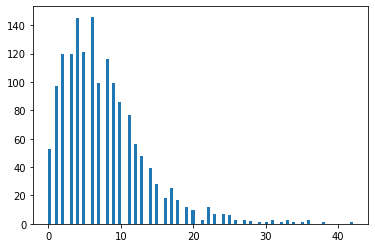

In [143]:
plt.hist((reduced_dataset['No. of Fertilized Oocytes'].to_numpy()), bins = 100)

In [128]:
v

3.5105737415781855

In [95]:
v, reg0, X_test_prog0 = prog_predict(X_train, X_test, [],'No. of Fertilized Oocytes')
v

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


task:         [regression]
metric:       [mean_absolute_error]
variant:      [A]
n_estimators: [3]

estimator  0: [lr: LinearRegression]
    fold  0:  [3.50820753]
    fold  1:  [3.62865687]
    fold  2:  [3.43973283]
    fold  3:  [3.80858289]
    ----
    MEAN:     [3.59629503] + [0.13998621]

estimator  1: [etc: ExtraTreesRegressor]
    fold  0:  [3.52406251]
    fold  1:  [3.54548604]
    fold  2:  [3.37568566]
    fold  3:  [3.60748802]
    ----
    MEAN:     [3.51318056] + [0.08508937]

estimator  2: [rf: RandomForestRegressor]
    fold  0:  [3.48776887]
    fold  1:  [3.54976101]
    fold  2:  [3.64563239]
    fold  3:  [3.79647170]
    ----
    MEAN:     [3.61990849] + [0.11642362]

Train set was detected.
Transforming...

estimator  0: [lr: LinearRegression]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [etc: ExtraTreesRegressor]
    model from fold  0: done
    model from fo

3.523177304891115

mean_absolute_error(y_test['fertilized_oocytes'], lr.predict(S_test))

In [99]:
v, reg0, X_test_prog0 = prog_predict_binary(X_train, X_test, [],'ret_oocy_cat')
v

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since sh

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [4]

estimator  0: [svm: Pipeline]
    fold  0:  [0.74528302]
    fold  1:  [0.72641509]
    fold  2:  [0.71069182]
    fold  3:  [0.72327044]
    ----
    MEAN:     [0.72641509] + [0.01238052]

estimator  1: [lr: Pipeline]
    fold  0:  [0.76100629]
    fold  1:  [0.75157233]
    fold  2:  [0.74842767]
    fold  3:  [0.72955975]
    ----
    MEAN:     [0.74764151] + [0.01141968]

estimator  2: [etc: ExtraTreesClassifier]
    fold  0:  [0.74213836]
    fold  1:  [0.75157233]
    fold  2:  [0.74213836]
    fold  3:  [0.70125786]
    ----
    MEAN:     [0.73427673] + [0.01944861]

estimator  3: [rf: RandomForestClassifier]
    fold  0:  [0.76100629]
    fold  1:  [0.78930818]
    fold  2:  [0.79874214]
    fold  3:  [0.74528302]
    ----
    MEAN:     [0.77358491] + [0.02144368]

Train set was detected.
Transforming...

estimator  0: [svm: Pipeline]
    model from fold  0: done

array([[ 94,  29],
       [ 47, 149]])

In [100]:
v, reg0, X_test_prog0 = prog_predict_binary(X_train, X_test, ['FD_count','E2_last_day','max_FD'],'ret_oocy_cat')
v

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [4]

estimator  0: [svm: Pipeline]
    fold  0:  [0.73584906]
    fold  1:  [0.75471698]
    fold  2:  [0.74528302]
    fold  3:  [0.74528302]
    ----
    MEAN:     [0.74528302] + [0.00667082]

estimator  1: [lr: Pipeline]
    fold  0:  [0.73584906]
    fold  1:  [0.75786164]
    fold  2:  [0.73899371]
    fold  3:  [0.75786164]
    ----
    MEAN:     [0.74764151] + [0.01028042]

estimator  2: [etc: ExtraTreesClassifier]
    fold  0:  [0.77987421]
    fold  1:  [0.77358491]
    fold  2:  [0.77672956]
    fold  3:  [0.73584906]
    ----
    MEAN:     [0.76650943] + [0.01784089]

estimator  3: [rf: RandomForestClassifier]
    fold  0:  [0.82075472]
    fold  1:  [0.78616352]
    fold  2:  [0.81761006]
    fold  3:  [0.75471698]
    ----
    MEAN:     [0.79481132] + [0.02681037]

Train set was detected.
Transforming...

estimator  0: [svm: Pipeline]
    model from fold  0: done

array([[ 96,  27],
       [ 37, 159]])

In [106]:
v, reg0, X_test_prog0 = prog_predict_binary(X_train, X_test, [],'mat_oocy_cat')
v

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise 

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [4]

estimator  0: [svm: Pipeline]
    fold  0:  [0.75786164]
    fold  1:  [0.72327044]
    fold  2:  [0.72641509]
    fold  3:  [0.71069182]
    ----
    MEAN:     [0.72955975] + [0.01736692]

estimator  1: [lr: Pipeline]
    fold  0:  [0.77044025]
    fold  1:  [0.74528302]
    fold  2:  [0.73584906]
    fold  3:  [0.74528302]
    ----
    MEAN:     [0.74921384] + [0.01284602]

estimator  2: [etc: ExtraTreesClassifier]
    fold  0:  [0.73270440]
    fold  1:  [0.71383648]
    fold  2:  [0.73584906]
    fold  3:  [0.69811321]
    ----
    MEAN:     [0.72012579] + [0.01524428]

estimator  3: [rf: RandomForestClassifier]
    fold  0:  [0.77044025]
    fold  1:  [0.73270440]
    fold  2:  [0.71698113]
    fold  3:  [0.69496855]
    ----
    MEAN:     [0.72877358] + [0.02753818]

Train set was detected.
Transforming...

estimator  0: [svm: Pipeline]
    model from fold  0: done

array([[142,  37],
       [ 39, 101]])

In [107]:
v, reg0, X_test_prog0 = prog_predict_binary(X_train, X_test, ['max_FD', 'E2_last_day','FD_count'],'mat_oocy_cat')
v

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [4]

estimator  0: [svm: Pipeline]
    fold  0:  [0.74213836]
    fold  1:  [0.74842767]
    fold  2:  [0.73270440]
    fold  3:  [0.73584906]
    ----
    MEAN:     [0.73977987] + [0.00603864]

estimator  1: [lr: Pipeline]
    fold  0:  [0.76100629]
    fold  1:  [0.75471698]
    fold  2:  [0.73584906]
    fold  3:  [0.75157233]
    ----
    MEAN:     [0.75078616] + [0.00926873]

estimator  2: [etc: ExtraTreesClassifier]
    fold  0:  [0.73270440]
    fold  1:  [0.74528302]
    fold  2:  [0.72327044]
    fold  3:  [0.73270440]
    ----
    MEAN:     [0.73349057] + [0.00782223]

estimator  3: [rf: RandomForestClassifier]
    fold  0:  [0.76100629]
    fold  1:  [0.76415094]
    fold  2:  [0.73270440]
    fold  3:  [0.75157233]
    ----
    MEAN:     [0.75235849] + [0.01225508]

Train set was detected.
Transforming...

estimator  0: [svm: Pipeline]
    model from fold  0: done

array([[143,  36],
       [ 37, 103]])

In [108]:
v, reg0, X_test_prog0 = prog_predict_binary(X_train, X_test, ['max_FD', 'E2_last_day', 'FD_count', 'No. of Retrieved Oocytes'],'mat_oocy_cat')
v

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [4]

estimator  0: [svm: Pipeline]
    fold  0:  [0.87421384]
    fold  1:  [0.85534591]
    fold  2:  [0.85534591]
    fold  3:  [0.87735849]
    ----
    MEAN:     [0.86556604] + [0.01028042]

estimator  1: [lr: Pipeline]
    fold  0:  [0.85220126]
    fold  1:  [0.88679245]
    fold  2:  [0.88050314]
    fold  3:  [0.92138365]
    ----
    MEAN:     [0.88522013] + [0.02461081]

estimator  2: [etc: ExtraTreesClassifier]
    fold  0:  [0.85220126]
    fold  1:  [0.85849057]
    fold  2:  [0.87421384]
    fold  3:  [0.87421384]
    ----
    MEAN:     [0.86477987] + [0.00969247]

estimator  3: [rf: RandomForestClassifier]
    fold  0:  [0.87735849]
    fold  1:  [0.86163522]
    fold  2:  [0.88050314]
    fold  3:  [0.91509434]
    ----
    MEAN:     [0.88364780] + [0.01951207]

Train set was detected.
Transforming...

estimator  0: [svm: Pipeline]
    model from fold  0: done

array([[163,  16],
       [ 20, 120]])

In [103]:
labels = ["0-5", "6-20", "20+"]

def plot_cm(cm, labels, figsize=(10,10)):
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax)

Text(0.5, 1, 'retrieved oocytes ~ preIVF')

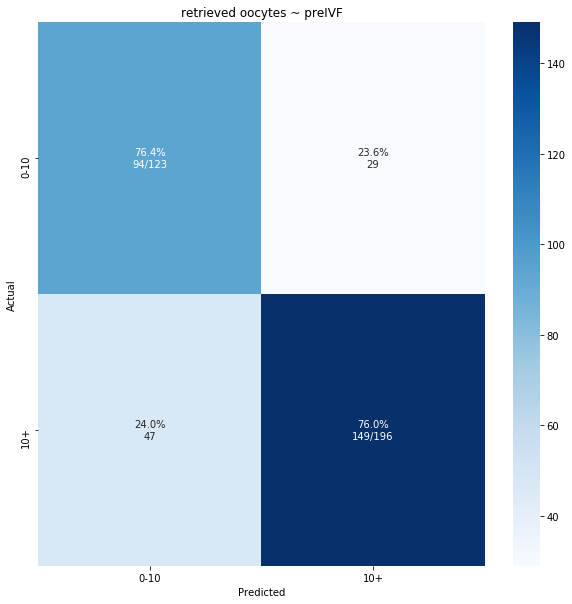

In [104]:
labels = ["0-10", "10+"]
plot_cm(np.array([[ 94,  29],
       [ 47, 149]]), labels)
plt.title("retrieved oocytes ~ preIVF")


Text(0.5, 1, 'retrieved oocytes ~ preIVF + last_visit')

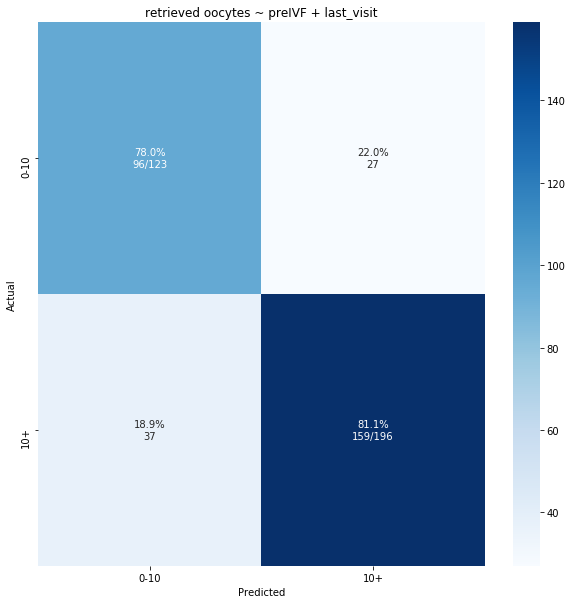

In [109]:
plot_cm(np.array([[ 96,  27],
       [ 37, 159]]), labels)
plt.title("retrieved oocytes ~ preIVF + last_visit")


Text(0.5, 1, 'matured oocytes ~ preIVF')

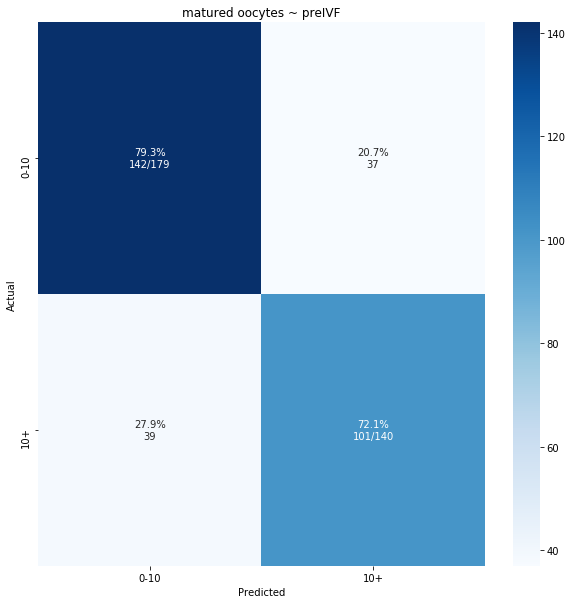

In [110]:
plot_cm(np.array([[142,  37],
       [ 39, 101]]), labels)
plt.title("matured oocytes ~ preIVF")

Text(0.5, 1, 'matured oocytes ~ preIVF + last_visit')

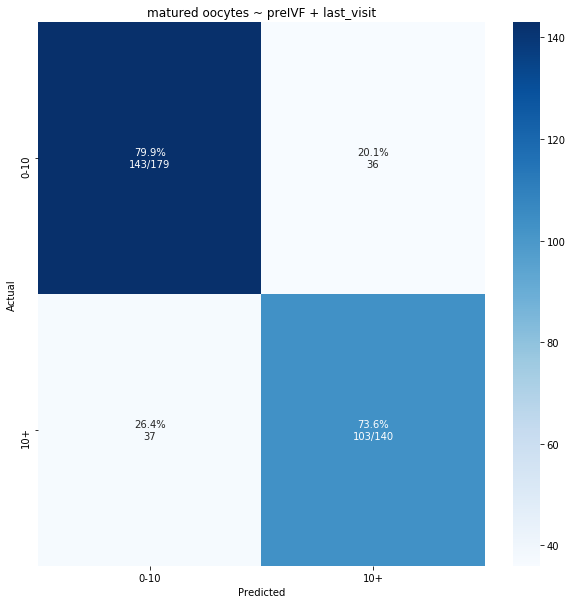

In [111]:
plot_cm(np.array([[143,  36],
       [ 37, 103]]), labels)
plt.title("matured oocytes ~ preIVF + last_visit")

Text(0.5, 1, 'matured oocytes ~ preIVF + last_visit + retrieved oocytes')

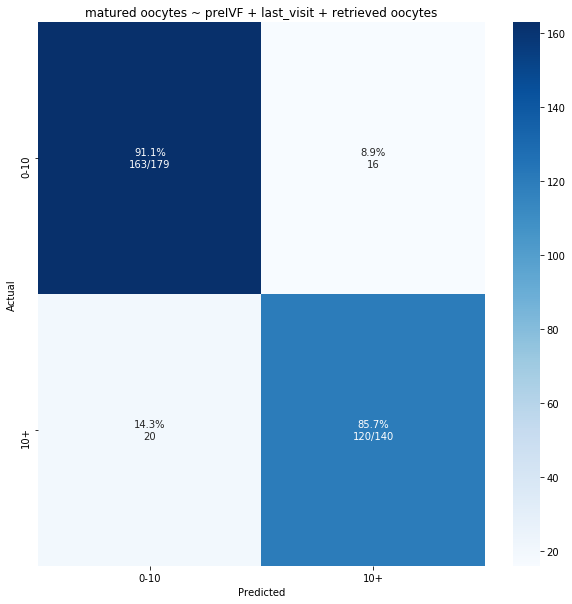

In [112]:
plot_cm(np.array([[163,  16],
       [ 20, 120]]), labels)
plt.title("matured oocytes ~ preIVF + last_visit + retrieved oocytes")

Text(0.5, 1, 'retrieved oocytes ~ preIVF')

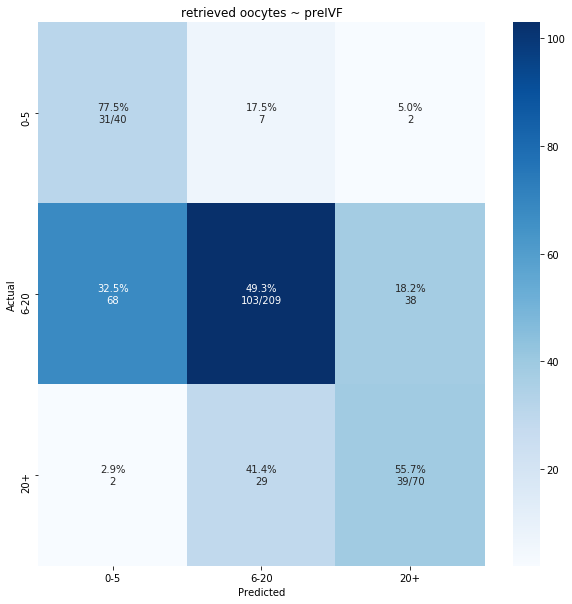

In [275]:
plot_cm(np.array([[ 31,   7,   2],
       [ 68, 103,  38],
       [  2,  29,  39]]), labels)
plt.title("retrieved oocytes ~ preIVF")

Text(0.5, 1, 'retrieved oocytes ~ preIVF  + last visit')

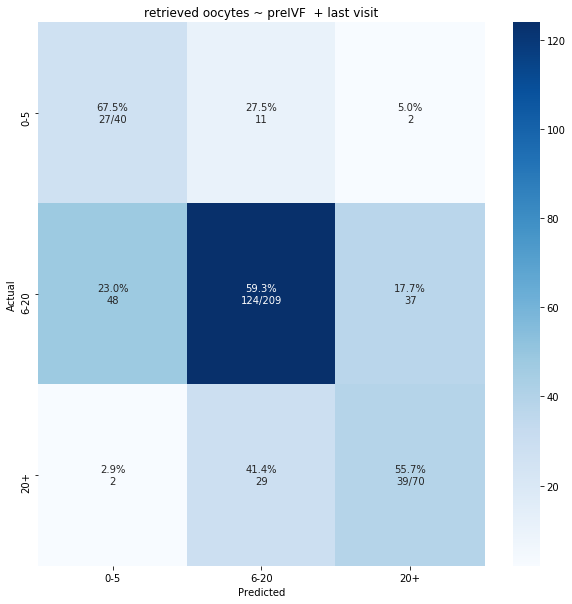

In [267]:
plot_cm(np.array([[ 27,  11,   2],
       [ 48, 124,  37],
       [  2,  29,  39]]), labels)
plt.title("retrieved oocytes ~ preIVF  + last visit")

Text(0.5, 1, 'matured oocytes ~ preIVF')

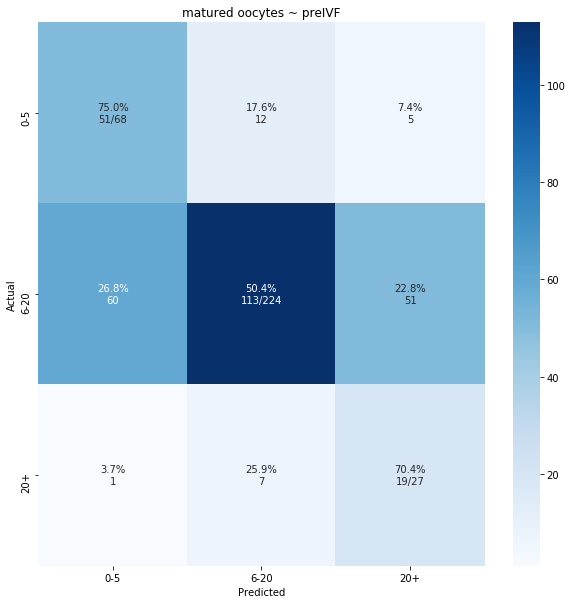

In [269]:
plot_cm(np.array([[ 51,  12,   5],
       [ 60, 113,  51],
       [  1,   7,  19]]), labels)
plt.title("matured oocytes ~ preIVF")

Text(0.5, 1, 'matured oocytes ~ preIVF + last visit')

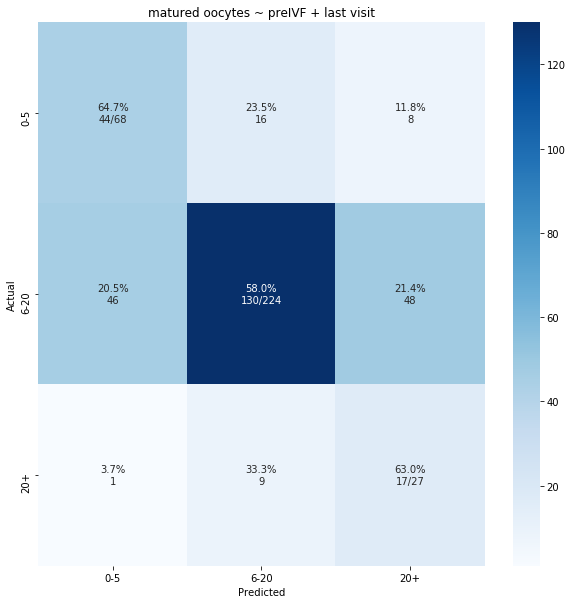

In [270]:
plot_cm(np.array([[ 44,  16,   8],
       [ 46, 130,  48],
       [  1,   9,  17]]), labels)
plt.title("matured oocytes ~ preIVF + last visit")

Text(0.5, 1, 'matured oocytes ~ preIVF + last visit + retrieved oocytes')

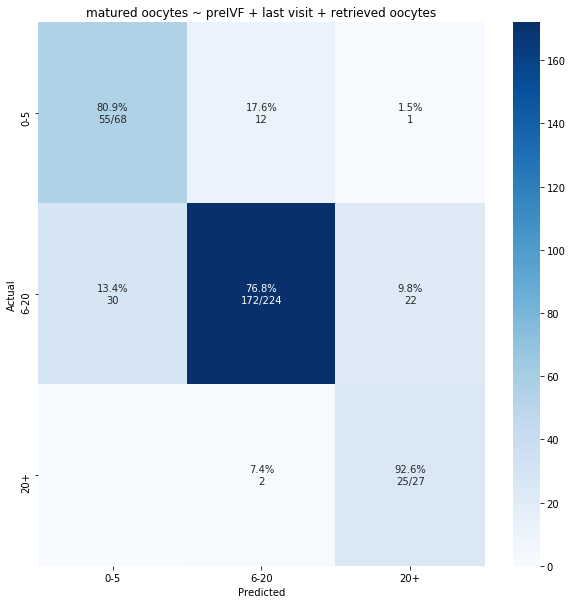

In [271]:
plot_cm(np.array([[ 55,  12,   1],
       [ 30, 172,  22],
       [  0,   2,  25]]), labels)
plt.title("matured oocytes ~ preIVF + last visit + retrieved oocytes")

In [188]:
y_train = X_train[X['male_infertility']==0]
y_test = X_test[X['male_infertility']==0]
#y_train

/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,max_dose,Patient Age (At Cycle Start),AMH,# prior IUI,male_infertility,FSH Dose Day 1,# prior FET,min_dose,AFC (Calc),end_dose,# prior IVF,BMI,dose_change,Smoked?_No,Smoked?_Unknown,Smoked?_Yes,Plan Stim Protocol_FSH Only,Plan Stim Protocol_FSH/HMG,Plan Stim Protocol_FSH/dilutedHCG,Plan Stim Protocol_Letrozole/FSH,Lupron Protocol_Antagonist,Lupron Protocol_LPL 10/5,Lupron Protocol_Lupron Microdose
1226,450.0,34.0,3.26,0.0,0.0,450.0,0.0,450.0,0.0,450.0,1.0,27.6,0.0,1,0,0,0,1,0,0,1,0,0
736,225.0,36.0,0.21,1.0,0.0,225.0,0.0,225.0,11.0,225.0,0.0,25.7,0.0,1,0,0,0,1,0,0,0,0,1
620,250.0,32.0,1.48,0.0,0.0,250.0,0.0,250.0,0.0,250.0,0.0,21.6,0.0,1,0,0,0,1,0,0,1,0,0
325,375.0,37.0,3.30,2.0,0.0,375.0,0.0,375.0,35.0,375.0,0.0,21.9,0.0,1,0,0,0,1,0,0,1,0,0
198,150.0,24.0,2.71,0.0,0.0,150.0,0.0,150.0,29.0,150.0,0.0,32.2,0.0,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,200.0,29.0,2.27,0.0,0.0,200.0,0.0,150.0,30.0,150.0,0.0,28.2,1.0,0,1,0,0,1,0,0,1,0,0
144,125.0,28.0,9.35,1.0,0.0,125.0,0.0,125.0,30.0,125.0,0.0,24.5,0.0,0,1,0,0,1,0,0,1,0,0
715,300.0,39.0,1.49,0.0,0.0,300.0,0.0,300.0,0.0,300.0,0.0,33.1,0.0,1,0,0,0,1,0,0,1,0,0
1096,225.0,29.0,12.95,1.0,0.0,225.0,0.0,225.0,0.0,225.0,0.0,37.4,0.0,0,1,0,0,1,0,0,1,0,0


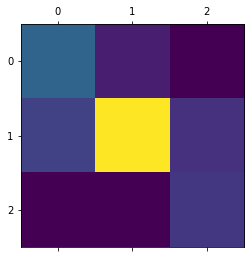

In [238]:
arr = np.array([[ 54,  14,   0],
       [ 33, 167,  24],
       [  0,   0,  27]])
plt.matshow(arr)

In [39]:
v2, reg2, X_test_prog2 = prog_predict(X_train, X_test, ['max_FD','E2_last_day','No. of Retrieved Oocytes','No. of Inseminated Oocytes'])
v2

task:         [regression]
metric:       [mean_absolute_error]
variant:      [A]
n_estimators: [3]

estimator  0: [lr: LinearRegression]
    fold  0:  [1.78739425]
    fold  1:  [2.06183651]
    fold  2:  [1.81962142]
    fold  3:  [1.86673000]
    ----
    MEAN:     [1.88389555] + [0.10653791]

estimator  1: [etc: ExtraTreesRegressor]


/Users/zhanshi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [1.81251780]
    fold  1:  [2.08205975]
    fold  2:  [1.77684022]
    fold  3:  [1.91472958]
    ----
    MEAN:     [1.89653684] + [0.11846540]

estimator  2: [rf: RandomForestRegressor]
    fold  0:  [1.84791384]
    fold  1:  [2.09513113]
    fold  2:  [1.85683679]
    fold  3:  [1.91847138]
    ----
    MEAN:     [1.92958829] + [0.09936236]

Train set was detected.
Transforming...

estimator  0: [lr: LinearRegression]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [etc: ExtraTreesRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  2: [rf: RandomForestRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

Transforming...

estimator  0: [lr: LinearRegression]
    model from fol

1.7303544923546068

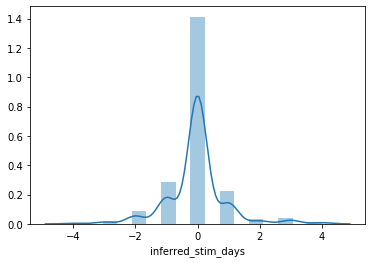

In [142]:
sns.distplot(-y_test_opt + rf.predict(X_test).round(), kde_kws={'bw': 0.3})

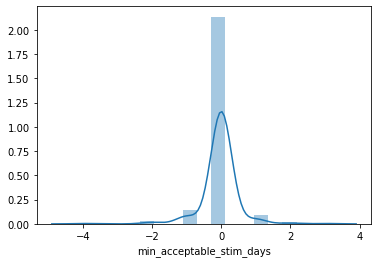

In [518]:
sns.distplot(y_test_min - rf_min.predict(X_test).round(), kde_kws={'bw': 0.3})

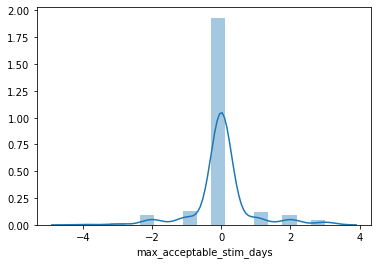

In [519]:
sns.distplot(y_test_max - rf_max.predict(X_test).round(), kde_kws={'bw': 0.3})

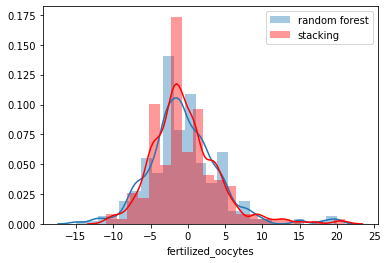

In [601]:

fig, ax = plt.subplots()

sns.distplot(y_test['fertilized_oocytes']-rf_oocy_ini.predict(X_test).round(), kde_kws={'bw': 0.8}, ax = ax,
            label = 'random forest')
sns.distplot(y_test['fertilized_oocytes']-lr.predict(S_test).round(), kde_kws={'bw': 0.8}, ax = ax, color='r', 
            label='stacking')
ax.legend()

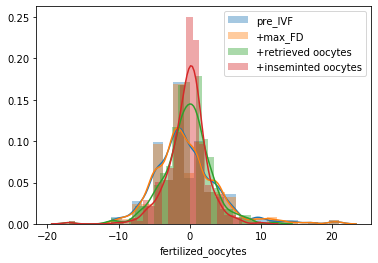

In [71]:
fig2, ax2 = plt.subplots()

sns.distplot(y_test['fertilized_oocytes']-lr.predict(S_test).round(), kde_kws={'bw': 0.8}, ax = ax2, 
            label='pre_IVF')
sns.distplot(y_test['fertilized_oocytes']-reg0.predict(X_test_prog0).round(), kde_kws={'bw': 0.8}, ax = ax2, 
            label='+max_FD')
sns.distplot(y_test['fertilized_oocytes']-reg.predict(X_test_prog1).round(), kde_kws={'bw': 0.8}, ax = ax2, 
            label='+retrieved oocytes')
sns.distplot(y_test['fertilized_oocytes']-reg2.predict(X_test_prog2).round(), kde_kws={'bw': 0.8}, ax = ax2, 
            label='+inseminted oocytes')
ax2.legend()

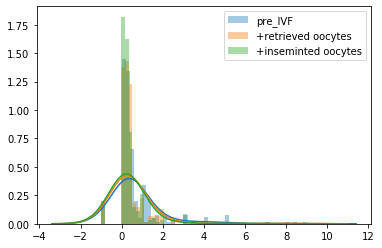

In [620]:
fig2, ax2 = plt.subplots()
n = len(y_test['fertilized_oocytes'])

ori_pred = lr.predict(S_test).round()
prog_1_pred = reg.predict(X_test_prog1).round()
prog_2_pred = reg.predict(X_test_prog2).round()
y = y_test['fertilized_oocytes']

def get_prec(pred):
    res = np.zeros(n)
    for i in range(n):
        if y.iloc[i] > 0:
            res[i] = abs(y.iloc[i] - pred[i])/y.iloc[i]
        else:
            res[i] = -1
    return res

sns.distplot(get_prec(ori_pred), kde_kws={'bw': 0.8}, ax = ax2, 
            label='pre_IVF')
sns.distplot(get_prec(prog_1_pred), kde_kws={'bw': 0.8}, ax = ax2, 
            label='+retrieved oocytes')
sns.distplot(get_prec(prog_2_pred), kde_kws={'bw': 0.8}, ax = ax2, 
            label='+inseminted oocytes')
ax2.legend()

In [617]:
ret mat 0~5 6~20 21+
   1 2 3
1 10 2 1
2 
3



8.0

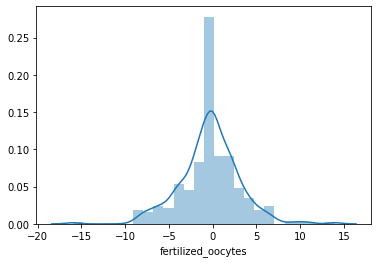

In [558]:
sns.distplot(y_test['fertilized_oocytes']-reg.predict(X_test_prog1).round(), kde_kws={'bw': 0.8})